In [1]:
import torch

from transformers import GPT2Model, GPT2Config, PreTrainedModel
from trader_models import SRUTrader
from datasets import load_dataset, Dataset, DatasetDict

from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

import numpy as np

import logging
logging.disable(logging.INFO)

In [2]:
def compute_metrics(preds):
    soft_profit, soft_trade = preds.predictions
    abs_trade = np.abs(soft_trade)
    abs_trade = abs_trade.astype('float64') # half precision will cause the sum to overflow on next line
    trades = abs_trade.sum()
    
    day_profits = soft_profit.sum(axis = (1, 2))
    
    metrics = {
        'day profit': day_profits.mean(),
        'day sharpe': day_profits.mean() / day_profits.std(),
        'trade %': trades * 100 / soft_profit.size,
        
        'full trade %': (abs_trade >= .8).mean() * 100,
        'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
        'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
                          / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
        
        'medium trade %': ((abs_trade < .8) & (abs_trade >= .5)).mean() * 100,
        'medium trade accuracy': (soft_profit[(abs_trade < .8) & (abs_trade >= .5)] > 0).mean() * 100,
        'medium trade g/l': soft_profit[(abs_trade < .8) & (abs_trade >= .5) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .8) & (abs_trade >= .5) & (soft_profit < 0)].mean(),       
        
        'small trade %': ((abs_trade < .5) & (abs_trade >= .2)).mean() * 100,
        'small trade accuracy': (soft_profit[(abs_trade < .5) & (abs_trade >= .2)] > 0).mean() * 100,
        'small trade g/l': soft_profit[(abs_trade < .5) & (abs_trade >= .2) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .5) & (abs_trade >= .2) & (soft_profit < 0)].mean(),
    }
    
    # round the metrics
    metrics = {k: np.format_float_positional(v, precision = 4) for k, v in metrics.items()}
    
    return metrics

In [3]:
fx = Dataset.load_from_disk('data/fx_days.ds')

# make splits
split = fx.train_test_split(.002, shuffle = False)
valid_test = split['test'].train_test_split(.5, shuffle = False)
fx = DatasetDict({
    'train': split['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

In [4]:
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = 500,
    eval_steps = 500,
    report_to = "none",
    learning_rate = 5e-5,
    weight_decay = .01,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    max_grad_norm = 1,
    fp16 = True,
)

In [5]:
config = GPT2Config(
    n_embd = 384, n_head = 6 * 2
)

In [6]:
model = SRUTrader(config)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)

In [7]:
# sru lr of 1e-4, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, .5 classification loss + .5 rr nll, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.717100,0.693747,0.1514,0.1636,7.6228,0.,nan,nan,0.0051,21.2821,0.7697,1.6179,52.3595,1.0044
1000,0.697700,0.692957,0.0034,0.0043,4.5296,0.,nan,nan,0.0248,7.2072,0.0495,0.2235,42.5318,0.1798
1500,0.694900,0.699272,0.0312,0.0325,9.4922,0.,nan,nan,0.0056,80.6527,1.3304,10.5715,52.4933,1.0329
2000,0.693500,0.692022,0.0789,0.1853,4.8924,0.,nan,nan,0.,nan,nan,0.3661,68.0546,0.5981
2500,0.693000,0.690215,0.1971,0.264,6.0723,0.,nan,nan,0.0000,0.,nan,0.7774,69.5721,0.5458
3000,0.692400,0.690883,0.2042,0.2576,6.6588,0.,nan,nan,0.0001,75.,1.8482,0.8015,68.1698,0.9901
3500,0.692400,0.691494,0.1089,0.3278,4.3362,0.,nan,nan,0.,nan,nan,0.6246,73.0368,0.7382
4000,0.692000,0.689541,0.2179,0.3769,5.2645,0.,nan,nan,0.0737,80.3071,1.0581,1.6695,70.289,0.8497
4500,0.692000,0.690450,0.1894,0.454,4.9846,0.,nan,nan,0.0080,86.9281,2.0731,1.1076,72.5458,1.0780
5000,0.692000,0.692612,0.1212,0.145,7.9661,0.,nan,nan,0.1947,78.2858,1.1479,4.1721,61.6112,0.8959


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=43908, training_loss=0.6909465659475938, metrics={'train_runtime': 16064.3508, 'train_samples_per_second': 5.466, 'train_steps_per_second': 2.733, 'total_flos': 0.0, 'train_loss': 0.6909465659475938, 'epoch': 1.0})

In [ ]:
trainer.evaluate(fx['test'])

In [9]:
# trainer.save_model('srupp.model')

# quick prediction test to ensure model isn't cheating

In [10]:
model = SRUTrader.from_pretrained('srupp.model', config = config).cuda().eval()

0
tensor([-28., -28., -27., -26., -26., -25., -25., -24., -24., -23., -23., -22.,
        -22., -22., -21., -21., -20., -20., -20., -19., -19., -19., -18., -18.,
        -18., -18., -17., -17., -16., -16., -16., -15., -15., -15., -14., -14.,
        -15., -14., -13., -13., -13., -13., -13., -13., -13., -12., -12., -12.,
        -12., -12., -11., -12., -11., -10., -11., -10., -10., -11., -10., -10.])


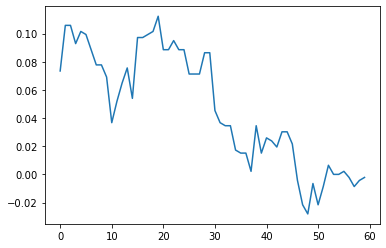

1
tensor([ -9.,  -8.,  -8.,  -8.,  -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -8.,
         -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -8.,  -9.,
         -9.,  -9.,  -9.,  -9., -10.,  -9., -10.,  -9., -10., -10.,  -9.,  -9.,
        -10., -10.,  -9., -10., -10., -10.,  -9., -10., -11., -10., -10., -10.,
        -10.,  -9., -11.,  -9., -10., -11., -10., -11., -11., -11., -11., -10.])


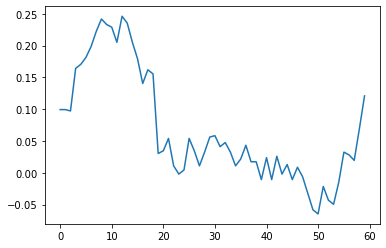

2
tensor([29., 27., 26., 24., 23., 23., 21., 21., 21., 21., 19., 19., 17., 16.,
        15., 18., 15., 15., 15., 15., 15., 15., 13., 13., 14., 14., 12., 13.,
        12., 13., 12., 13., 12., 12., 11., 12., 12., 12., 11., 12., 12., 12.,
        11., 11., 12., 11., 11., 11., 11., 13., 11., 11., 11., 12., 10., 12.,
        12.,  9., 10., 11.])


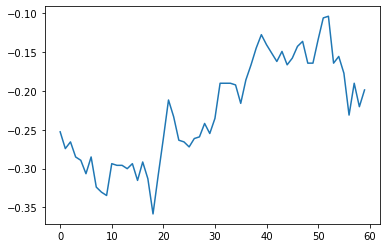

3
tensor([-12., -13., -13., -12., -14., -14., -13., -13., -13., -13., -14., -14.,
        -14., -14., -14., -14., -15., -15., -15., -15., -14., -15., -16., -15.,
        -16., -15., -15., -15., -15., -16., -16., -16., -15., -16., -16., -17.,
        -17., -17., -17., -17., -18., -17., -18., -18., -16., -17., -17., -17.,
        -18., -17., -16., -17., -17., -16., -17., -17., -16., -17., -18., -17.])


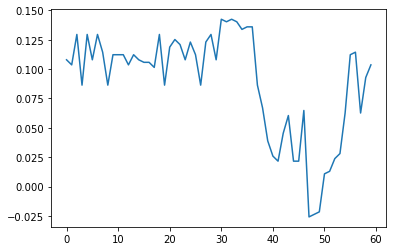

In [11]:
import matplotlib.pyplot as plt

for day in range(4):
    # cut data short so no backwards flow of info
    test_day = torch.tensor(fx['validation']['ohlcv'][day][:]).unsqueeze(0).cuda()
    test_futures = torch.tensor(fx['validation']['future'][day][:]).unsqueeze(0).cuda()
    after = torch.tensor(fx['validation']['ohlcv'][day][1440 - 1380:1440-1320])
    with torch.no_grad():
        # no access to futures
        pred = model(test_day, test_futures)['trades'][0][60]
    torch.cuda.empty_cache()
#     if (pred.abs() >= .9).any():
    if True:
        print(day)
#         plt.pcolormesh(pred.cpu().unsqueeze(0))
        plt.show()
        print((pred.cpu() * 100).round())
        
        plt.plot(after.select(dim = 1, index = -1))
        plt.show()

0
tensor([-28., -28., -27., -26., -26., -25., -25., -24., -24., -23., -23., -22.,
        -22., -22., -21., -21., -20., -20., -20., -19., -19., -19., -18., -18.,
        -18., -18., -17., -17., -16., -16., -16., -15., -15., -15., -14., -14.,
        -15., -14., -13., -13., -13., -13., -13., -13., -13., -12., -12., -12.,
        -12., -12., -11., -12., -11., -10., -11., -10., -10., -11., -10., -10.])


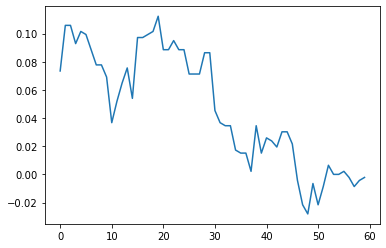

1
tensor([ -9.,  -8.,  -8.,  -8.,  -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -8.,
         -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -9.,  -8.,  -9.,
         -9.,  -9.,  -9.,  -9., -10.,  -9., -10.,  -9., -10., -10.,  -9.,  -9.,
        -10., -10.,  -9., -10., -10., -10.,  -9., -10., -11., -10., -10., -10.,
        -10.,  -9., -11.,  -9., -10., -11., -10., -11., -11., -11., -11., -10.])


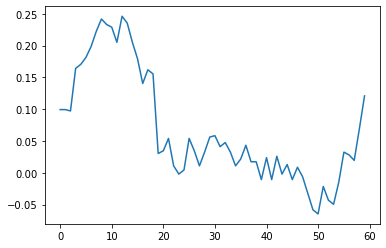

2
tensor([29., 27., 26., 24., 23., 23., 21., 21., 21., 21., 19., 19., 17., 16.,
        15., 18., 15., 15., 15., 15., 15., 15., 13., 13., 14., 14., 12., 13.,
        12., 13., 12., 13., 12., 12., 11., 12., 12., 12., 11., 12., 12., 12.,
        11., 11., 12., 11., 11., 11., 11., 13., 11., 11., 11., 12., 10., 12.,
        12.,  9., 10., 11.])


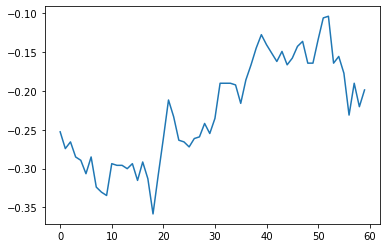

3
tensor([-12., -13., -13., -12., -14., -14., -13., -13., -13., -13., -14., -14.,
        -14., -14., -14., -14., -15., -15., -15., -15., -14., -15., -16., -15.,
        -16., -15., -15., -15., -15., -16., -16., -16., -15., -16., -16., -17.,
        -17., -17., -17., -17., -18., -17., -18., -18., -16., -17., -17., -17.,
        -18., -17., -16., -17., -17., -16., -17., -17., -16., -17., -18., -17.])


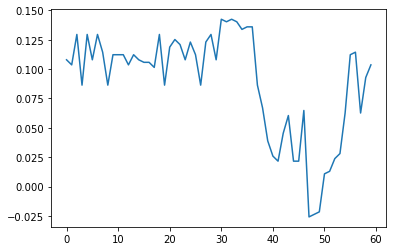

In [12]:
import matplotlib.pyplot as plt

for day in range(4):
    # cut data short so no backwards flow of info
    test_day = torch.tensor(fx['validation']['ohlcv'][day][:61]).unsqueeze(0).cuda()
    after = torch.tensor(fx['validation']['ohlcv'][day][1440 - 1380:1440 - 1320])
    with torch.no_grad():
        # no access to futures
        pred = model(test_day, torch.zeros(1, 61, 60).cuda())['trades'][0][60]
    torch.cuda.empty_cache()
#     if (pred.abs() >= .9).any():
    if True:
        print(day)
#         plt.pcolormesh(pred.cpu().unsqueeze(0))
        plt.show()
        print((pred.cpu() * 100).round())
        
        plt.plot(after.select(dim = 1, index = -1))
        plt.show()

# TODO: graph these instead of showing raw data (maybe even on same plot or at least side by side)

In [8]:
soft_profit, soft_trade = trainer.predict(fx['validation']).predictions

In [15]:
soft_profit.sum(axis = (1, 2))

0.1033431092898051

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  3.,  7., 15., 17., 23., 10.,  9.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([-4.235243  , -3.9784305 , -3.7216184 , -3.464806  , -3.207994  ,
        -2.9511817 , -2.6943696 , -2.4375572 , -2.1807451 , -1.9239328 ,
        -1.6671206 , -1.4103084 , -1.1534961 , -0.8966839 , -0.63987166,
        -0.38305944, -0.12624721,  0.13056502,  0.38737723,  0.6441895 ,
         0.9010017 ,  1.1578139 ,  1.4146261 ,  1.6714383 ,  1.9282506 ,
         2.185063  ,  2.441875  ,  2.6986873 ,  2.9554994 ,  3.2123117 ,
         3.4691238 ,  3.7259362 ,  3.9827485 ,  4.2395606 ,  4.4963727 ,
         4.7531853 ,  5.0099974 ,  5.2668095 ,  5.5236216 ,  5.780434  ,
         6.037246  ], dtype=float32),
 <BarContainer object of 40 artists>)

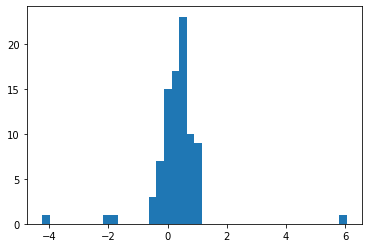

In [12]:
import matplotlib.pyplot as plt

plt.hist(soft_profit.sum(axis = (1, 2)), bins = 40)

In [13]:
soft_profit, soft_trade = trainer.predict(fx['validation']).predictions

In [14]:
soft_profit.sum(axis = (1, 2))

array([ 3.146163  ,  3.336661  ,  4.751307  ,  3.8030276 ,  2.9378438 ,
        0.6443328 ,  5.5824585 ,  5.4163084 , -0.63335735,  2.2472026 ,
        4.194634  ,  4.98759   ,  7.823779  ,  6.431118  ,  5.8439894 ,
        3.8191404 ,  3.2005472 ,  6.940066  ,  7.6015143 ,  5.3680983 ,
        5.3798895 ,  2.423078  ,  3.781556  ,  6.532161  ,  1.2018971 ,
        4.0689554 , -0.295049  ,  5.5675607 ,  4.9204726 ,  8.21875   ,
        1.5538099 ,  4.9764657 ,  9.386887  ,  9.459252  ,  3.9148757 ,
        5.617646  ,  1.0219431 ,  6.381312  ,  5.882002  , 11.352934  ,
        3.1836631 ,  1.667901  , 10.258092  ,  7.6650186 ,  6.6002207 ,
        4.9461317 ,  4.0588117 ,  5.1939926 ,  8.249453  ,  8.614871  ,
        2.291051  ,  2.0239325 ], dtype=float32)

(array([2., 0., 2., 3., 3., 2., 4., 6., 2., 5., 8., 3., 2., 2., 3., 1., 2.,
        0., 1., 1.]),
 array([-0.63335735, -0.03404278,  0.5652718 ,  1.1645863 ,  1.7639009 ,
         2.3632154 ,  2.9625301 ,  3.5618446 ,  4.161159  ,  4.7604737 ,
         5.3597884 ,  5.9591026 ,  6.5584173 ,  7.157732  ,  7.7570467 ,
         8.356361  ,  8.955676  ,  9.55499   , 10.1543045 , 10.753619  ,
        11.352934  ], dtype=float32),
 <BarContainer object of 20 artists>)

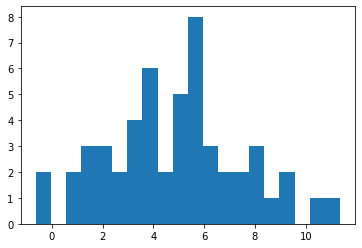

In [15]:
import matplotlib.pyplot as plt

plt.hist(soft_profit.sum(axis = (1, 2)), bins = 20)

In [16]:
# full trade percent on 24 hours, ignoring last hour, it makes most trades in london and ny sessions (esp overlap)
((np.abs(soft_trade) > .3).mean(axis = (0, 2)).reshape(-1, 60).mean(axis = 1) * 100).round()

array([16., 12., 11., 15., 15., 16., 21., 22., 22., 18., 16., 16., 18.,
       17., 14., 18., 18., 21., 19., 16., 19., 16., 17., 15.])

In [17]:
# full trade accuracy on 24 hours
np.nanmean(np.where(np.abs(soft_trade) > .3, soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

array([0.69446492, 0.7041928 , 0.69969238, 0.79701535, 0.82140611,
       0.68010861, 0.70502329, 0.6596424 , 0.67937353, 0.78398807,
       0.73097569, 0.63121417, 0.63159309, 0.69314033, 0.76863537,
       0.79703475, 0.77139077, 0.79376282, 0.77966472, 0.74946973,
       0.71607711, 0.75444882, 0.68099463, 0.49732145])

In [18]:
# full trade profit on 24 hours
np.nanmean(np.where(np.abs(soft_trade) > .3, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

array([1.1876332e-04, 7.9555248e-05, 8.9724090e-05, 2.0776977e-04,
       2.2739552e-04, 1.9607587e-04, 2.3662040e-04, 1.5102333e-04,
       1.6064881e-04, 3.2273741e-04, 3.4607961e-04, 1.6732531e-04,
       1.8424225e-04, 2.5854533e-04, 2.5242902e-04, 4.2365500e-04,
       3.7828193e-04, 4.0696230e-04, 2.7067726e-04, 1.6100329e-04,
       1.5087101e-04, 1.8252010e-04, 6.6967070e-05, 2.8061208e-05],
      dtype=float32)

In [19]:
# percent full trades on all timeframes
(np.abs(soft_trade) > .2).mean(axis = (0, 1))

array([0.24269498, 0.22913996, 0.22526709, 0.21716079, 0.22140759,
       0.22558761, 0.22913996, 0.23214476, 0.23660524, 0.24715545,
       0.25369925, 0.25767895, 0.26111111, 0.27170139, 0.27892628,
       0.28031517, 0.28950321, 0.29744925, 0.30377938, 0.30733173,
       0.30844017, 0.31991186, 0.3203125 , 0.33035524, 0.32546741,
       0.33545673, 0.34324252, 0.34237447, 0.34966613, 0.34592682,
       0.3536859 , 0.35742521, 0.36494391, 0.36451656, 0.36977831,
       0.36857639, 0.37086004, 0.38129006, 0.37457265, 0.38157051,
       0.39038462, 0.38624466, 0.39688835, 0.39403045, 0.39551282,
       0.39703526, 0.39618056, 0.39659455, 0.39919872, 0.40169605,
       0.39521902, 0.40048077, 0.40391293, 0.40108173, 0.39638088,
       0.3984375 , 0.40198985, 0.409375  , 0.40403312, 0.40399306])

In [20]:
# full trade accuracy on all timeframes
np.nanmean(np.where(np.abs(soft_trade) > .2, soft_profit > 0, np.nan), axis = (0, 1))

array([0.60056127, 0.60956988, 0.61921982, 0.63224894, 0.63031546,
       0.63521193, 0.63428138, 0.64298453, 0.64553818, 0.64948398,
       0.65036585, 0.65628401, 0.66105769, 0.66163677, 0.66527818,
       0.67017627, 0.67363225, 0.67543663, 0.68013364, 0.677617  ,
       0.68120021, 0.6841578 , 0.69272462, 0.69244452, 0.69311887,
       0.69262311, 0.69278655, 0.69294379, 0.69315968, 0.69296993,
       0.69415496, 0.69615902, 0.69594174, 0.69576846, 0.69579978,
       0.69560491, 0.69279798, 0.69486183, 0.69869509, 0.69739605,
       0.69536809, 0.69594081, 0.69322656, 0.69415353, 0.69428687,
       0.69502186, 0.69419538, 0.69582786, 0.69677506, 0.69566807,
       0.69405961, 0.69271042, 0.69446189, 0.6946026 , 0.69384455,
       0.69237473, 0.68964486, 0.68986103, 0.69065248, 0.68840699])

In [29]:
# full trade gain on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .3) & (soft_profit > 0), soft_profit, np.nan), axis = (0, 1))

array([8.43200469e-05, 1.02477410e-04, 1.14363706e-04, 1.23920734e-04,
       1.35454073e-04, 1.43878409e-04, 1.52047389e-04, 1.62791883e-04,
       1.69513922e-04, 1.83368393e-04, 1.90410603e-04, 2.03069736e-04,
       2.14261745e-04, 2.26516611e-04, 2.34651990e-04, 2.45005678e-04,
       2.56667117e-04, 2.66958232e-04, 2.75434868e-04, 2.86702765e-04,
       2.95763544e-04, 3.03910318e-04, 3.13204102e-04, 3.22068197e-04,
       3.23805347e-04, 3.37724370e-04, 3.45053646e-04, 3.47957219e-04,
       3.57328303e-04, 3.65508080e-04, 3.72693903e-04, 3.75242467e-04,
       3.80011770e-04, 3.87575652e-04, 3.93566064e-04, 4.00974561e-04,
       4.07650339e-04, 4.12724738e-04, 4.18077718e-04, 4.27969615e-04,
       4.30317974e-04, 4.36709321e-04, 4.48593113e-04, 4.47569008e-04,
       4.52995126e-04, 4.61952295e-04, 4.69913532e-04, 4.79373353e-04,
       4.76125104e-04, 4.91205312e-04, 4.92344901e-04, 4.98317066e-04,
       5.08682104e-04, 5.11977822e-04, 5.11613500e-04, 5.19939349e-04,
      

In [30]:
# full trade loss on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .3) & (soft_profit < 0), soft_profit, np.nan), axis = (0, 1))

array([-5.15397442e-05, -6.53635871e-05, -7.43142737e-05, -8.13606603e-05,
       -8.48082273e-05, -8.99201841e-05, -9.40361206e-05, -9.93004433e-05,
       -1.02869373e-04, -1.07765394e-04, -1.10062654e-04, -1.16147254e-04,
       -1.18855969e-04, -1.23831254e-04, -1.27782725e-04, -1.29165070e-04,
       -1.34463684e-04, -1.40263699e-04, -1.45703787e-04, -1.46901963e-04,
       -1.49713305e-04, -1.59088275e-04, -1.63918070e-04, -1.70321713e-04,
       -1.71522508e-04, -1.73591354e-04, -1.79329902e-04, -1.85799916e-04,
       -1.90269711e-04, -1.92671898e-04, -1.96338791e-04, -2.00813505e-04,
       -2.08427780e-04, -2.09257458e-04, -2.11486287e-04, -2.19790672e-04,
       -2.20184666e-04, -2.25161144e-04, -2.26787452e-04, -2.34397216e-04,
       -2.45083065e-04, -2.44880444e-04, -2.53888604e-04, -2.53017060e-04,
       -2.58708926e-04, -2.58548622e-04, -2.63650960e-04, -2.66840187e-04,
       -2.70061166e-04, -2.77392974e-04, -2.71283672e-04, -2.82921130e-04,
       -2.86742812e-04, -

In [25]:
# del trainer
# del model
# torch.cuda.empty_cache()

# Appendix

## gpt2 experiements

In [149]:
class GPT2Trader(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        
        # use levine 2020 layer numbers
        n_layer = round((math.log(config.n_embd) - 5.039) / 5.55e-2)
        n_layer = max(1, n_layer)
        print(f'Using {n_layer} layers')
        config.n_layer = n_layer
        
        config.initializer_range = 1 / math.sqrt(config.n_embd)
        
        self.embed = nn.Linear(5, config.n_embd, bias = False)
        self.norm = nn.LayerNorm(config.n_embd)
        self.gpt = GPT2Model(config)
        self.trade = nn.Linear(config.n_embd, 60, bias = False)


    def forward(self, ohlcv, future):
        embed = self.norm(self.embed(ohlcv))
        hidden = self.gpt(inputs_embeds = embed).last_hidden_state
        
        soft_trade = self.trade(hidden)
        
        # sharpe information
        soft_trade = torch.tanh(soft_trade)
        soft_profit = soft_trade * future
        
        # the exp is so that loss is purely positive and minimizes toward 0 (also losses have more loss than profit)
        loss_ppl = torch.square(-soft_profit + future.abs()).mean()
        
        # penalty for big trades (to stop trading from happening with no profit)
        trade_penalty = soft_trade.abs().mean()
        
        loss = loss_ppl# + .1 * trade_penalty # .1 means that a 100% position must make at least .1 of a std to offset loss
        
        return {
            'loss': loss,
            'profits': soft_profit,
            'trades': soft_trade,
        }

In [150]:
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = 100,
    eval_steps = 100,
    report_to = "none",
    learning_rate = 5e-4,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    max_grad_norm = 1,
)

In [151]:
config = GPT2Config(
    n_embd = 384, n_head = 6, vocab_size = 0, n_positions = 2000,
    resid_pdrop = .01, embd_pdrop = .01, attn_pdrop = .01, # low dropout since only using 1 epoch training and to make model more robust to data issues (.1 has worse loss, accuracy & t-score)
    summary_first_dropout = 0, summary_proj_to_labels = False,
    scale_attn_by_inverse_layer_idx = True, use_cache = False
)
model = GPT2Trader(config)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)

Using 16 layers


In [24]:
trainer.train()

## SRU experiments

In [7]:
# sru lr of 1e-4, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, classification loss + .005 rr nll, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.709000,0.689761,0.4739,0.6557,8.7540,0.,nan,nan,0.0005,42.8571,1.3973,5.3432,56.388,1.0067
1000,0.698100,0.690077,0.349,0.5579,7.5694,0.,nan,nan,0.0039,62.5,1.5464,2.8826,58.4797,0.998
1500,0.695500,0.690247,0.3899,1.2262,7.9306,0.0000,0.,nan,0.028,67.5159,1.3387,4.3620,57.9869,1.0712
2000,0.694300,0.688820,0.5439,1.4478,8.4102,0.0000,0.,nan,0.0111,71.,1.6546,5.5622,59.5550,1.1752
2500,0.692000,0.686264,0.6734,1.1399,7.9899,0.0003,100.,nan,0.0681,72.2549,1.7043,4.7872,63.3645,1.5212
3000,0.691800,0.688142,0.3663,1.5413,5.4911,0.0000,100.,nan,0.0365,78.6455,1.6011,1.1059,66.3661,1.2411
3500,0.691000,0.687976,0.3816,1.8101,4.8965,0.0004,66.6667,2.0751,0.0407,75.5057,1.3782,0.7429,67.3568,1.3061
4000,0.691000,0.685065,0.8707,1.0157,9.8884,0.0135,86.6116,1.6552,0.493,71.2944,1.4696,11.3422,59.6168,1.0517
4500,0.691400,0.686611,0.7381,1.2566,7.0685,0.0000,100.,nan,0.0841,73.7497,2.4151,5.3820,63.6474,1.8163
5000,0.690000,0.684650,0.7341,0.9407,7.4025,0.0026,83.1933,2.5319,0.1971,77.8254,2.1277,4.8238,64.1296,1.3769


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=34325, training_loss=0.6866331594179602, metrics={'train_runtime': 10248.899, 'train_samples_per_second': 3.349, 'train_steps_per_second': 3.349, 'total_flos': 0.0, 'train_loss': 0.6866331594179602, 'epoch': 1.0})

In [7]:
## doesn't converge

# sru lr of 2e-4, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, classification loss + .002 rr nll, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.706300,0.689819,0.4114,0.7155,7.5012,0.,nan,nan,0.0002,57.1429,0.4550,2.9301,56.5739,1.0356
1000,0.697700,0.691707,0.3095,0.7681,7.7874,0.,nan,nan,0.0017,46.0526,1.0548,3.3871,56.897,1.0044
1500,0.694600,0.689903,0.3231,1.7436,6.1121,0.,nan,nan,0.0124,61.1807,1.4077,1.3200,59.5683,1.208
2000,0.693100,0.689525,0.3303,1.6949,5.5141,0.,nan,nan,0.0156,64.4286,1.8321,0.6412,64.6150,1.4197
2500,0.692300,0.689978,0.2703,0.9524,4.5176,0.,nan,nan,0.0256,80.1215,1.6426,0.0761,69.3185,1.2679
3000,0.692500,0.690180,0.222,1.3949,3.6369,0.,nan,nan,0.0408,80.4146,1.9915,0.1125,65.9478,2.0771
3500,0.691900,0.690830,0.1637,0.812,2.8082,0.0003,14.2857,0.1045,0.0503,74.845,1.798,0.0301,61.226,1.0809
4000,0.692600,0.691474,0.0852,0.1169,6.0106,0.,nan,nan,0.0173,83.5476,1.7330,0.0811,68.8358,2.0755
4500,0.692000,0.690554,0.1436,0.5720,2.6011,0.,nan,nan,0.0414,83.2796,2.2697,0.0666,66.7112,1.9994
5000,0.691400,0.690344,0.1345,0.2322,4.5385,0.0000,0.,nan,0.0475,81.6690,2.6257,0.1016,65.2355,1.7385


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [7]:
# sru lr of 5e-5, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, classification loss + .002 rr nll, rotary embeddings, .1 dropout
# weight decay, head size of 64, diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.711400,0.689887,0.4274,0.7853,7.9735,0.,nan,nan,0.0012,65.3846,1.5627,3.8338,57.2302,1.0116
1000,0.698500,0.690703,0.3035,0.5216,7.1372,0.,nan,nan,0.0003,38.4615,3.4082,2.1305,58.1586,1.0106
1500,0.695600,0.690064,0.3493,0.9180,6.9818,0.,nan,nan,0.0088,62.2166,1.4452,2.8067,59.2344,1.0916
2000,0.694700,0.689753,0.4114,0.995,7.5603,0.,nan,nan,0.0034,63.871,2.1435,3.3884,59.8819,1.1307
2500,0.692400,0.687190,0.6213,0.9883,8.1916,0.,nan,nan,0.0219,66.4293,1.8356,4.3882,62.3227,1.3109
3000,0.692600,0.688171,0.5630,1.4967,8.476,0.,nan,nan,0.1246,75.2502,1.0341,6.9850,59.4341,1.2055
3500,0.691300,0.686324,0.7530,1.5588,7.8239,0.,nan,nan,0.0282,72.6914,1.9773,4.9106,64.2465,1.5526
4000,0.691400,0.686135,0.9498,0.8582,11.3257,0.0002,71.4286,2.1422,0.3354,71.3167,1.1324,14.9488,59.4325,1.1228
4500,0.691500,0.685359,0.7101,1.8179,5.8210,0.,nan,nan,0.0388,75.1435,1.7868,2.8337,68.4301,1.7642
5000,0.690000,0.683880,1.0146,1.1588,9.0483,0.0040,86.6667,2.1078,0.4797,72.4805,1.5161,9.4937,61.2811,1.1980


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=34325, training_loss=0.6866225922897794, metrics={'train_runtime': 10345.4315, 'train_samples_per_second': 3.318, 'train_steps_per_second': 3.318, 'total_flos': 0.0, 'train_loss': 0.6866225922897794, 'epoch': 1.0})

In [7]:
# sru lr of 3e-5, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, classification loss + .002 rr nll, rotary embeddings, .1 dropout
# weight decay, head size of 64, diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.713800,0.690994,0.341,0.5231,7.7361,0.,nan,nan,0.0007,51.6129,1.0332,3.5041,55.3700,0.9928
1000,0.699400,0.690162,0.2848,0.6593,5.9049,0.,nan,nan,0.0001,75.,1.1189,0.5392,61.8065,1.0935
1500,0.695800,0.689969,0.3323,0.8289,6.6327,0.,nan,nan,0.0032,63.4483,1.4514,1.2364,61.2425,1.1352
2000,0.694900,0.689694,0.3883,0.9963,6.9969,0.,nan,nan,0.0012,68.5185,1.5252,2.0116,61.3364,1.1298
2500,0.692700,0.687162,0.6208,1.0262,7.8524,0.,nan,nan,0.0188,64.9704,1.7243,4.5286,62.1843,1.3602
3000,0.692900,0.688429,0.4579,1.0216,7.4669,0.,nan,nan,0.0273,75.8367,0.9814,4.2537,60.1653,1.1819
3500,0.691600,0.687256,0.8134,1.5342,9.462,0.,nan,nan,0.1003,74.8557,1.3247,9.4202,60.2934,1.3031
4000,0.691700,0.685558,0.9891,0.9489,11.3926,0.0028,87.4016,0.8315,0.3897,70.2798,1.2635,14.7521,59.9081,1.155
4500,0.691800,0.685518,0.7339,1.6331,6.6424,0.,nan,nan,0.0495,74.4374,1.4401,2.9982,66.3776,1.7217
5000,0.690500,0.684161,0.9502,1.0827,9.1397,0.0037,84.1463,1.7469,0.3235,72.1706,1.2335,8.8068,61.3403,1.2320


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=34325, training_loss=0.68685490685315, metrics={'train_runtime': 10606.4955, 'train_samples_per_second': 3.236, 'train_steps_per_second': 3.236, 'total_flos': 0.0, 'train_loss': 0.68685490685315, 'epoch': 1.0})

In [7]:
# sru lr of 5e-5, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, classification loss + .005 rr nll, rotary embeddings, .1 dropout
# weight decay, head size of 64, diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.712900,0.689662,0.4711,0.7743,8.5183,0.,nan,nan,0.0014,52.4590,0.9818,5.5081,57.0283,1.0096
1000,0.698800,0.690301,0.3286,0.6024,7.2132,0.,nan,nan,0.0033,50.6757,1.2677,2.0912,57.8540,1.1144
1500,0.695600,0.689921,0.3627,0.8402,7.3507,0.,nan,nan,0.0192,65.9722,1.4358,2.9655,59.7888,1.0557
2000,0.694800,0.688695,0.5481,1.4296,8.4287,0.,nan,nan,0.0114,66.4706,1.5849,5.7703,59.2116,1.1781
2500,0.692200,0.685781,0.7638,1.0052,9.0005,0.,nan,nan,0.0574,69.6242,1.3898,7.5301,62.3860,1.3466
3000,0.692600,0.687074,0.5989,1.4351,8.3495,0.0027,86.6667,1.4033,0.1811,71.9676,1.1998,6.0836,60.3918,1.1339
3500,0.690900,0.685610,0.76,1.6791,7.6163,0.0004,68.75,4.5856,0.0692,73.3441,1.5415,4.411,64.4664,1.5480
4000,0.691100,0.684654,0.9413,0.9978,10.0947,0.0001,66.6667,nan,0.1327,74.6016,1.4454,11.0986,60.9756,1.1868
4500,0.691300,0.684215,0.7799,1.6314,6.6257,0.0001,60.,0.5919,0.0518,73.7430,1.6208,3.6630,67.8287,1.7604
5000,0.689600,0.683513,0.9646,1.0580,8.8586,0.0043,85.0515,1.1199,0.4351,72.2427,1.3312,9.0957,60.6543,1.1260


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=34325, training_loss=0.6859942120179068, metrics={'train_runtime': 10343.2308, 'train_samples_per_second': 3.319, 'train_steps_per_second': 3.319, 'total_flos': 0.0, 'train_loss': 0.6859942120179068, 'epoch': 1.0})

In [7]:
# sru lr of 5e-5, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, classification loss + .001 rr nll, rotary embeddings, .1 dropout
# weight decay, head size of 64, diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.711500,0.690188,0.4227,0.6803,8.0204,0.,nan,nan,0.0007,66.6667,2.656,3.5946,56.15,1.0175
1000,0.698400,0.690412,0.3050,0.5386,6.6183,0.,nan,nan,0.0001,66.6667,0.1008,0.8309,60.5722,0.9716
1500,0.695600,0.690155,0.3551,1.0433,7.1047,0.,nan,nan,0.0045,62.,1.0884,1.7647,60.0959,1.1259
2000,0.694600,0.689735,0.4357,1.1956,7.5503,0.,nan,nan,0.0013,60.,1.2388,3.7534,59.0983,1.0864
2500,0.692500,0.687130,0.6838,1.0542,8.6868,0.,nan,nan,0.0226,69.1249,1.5691,6.0375,62.2543,1.356
3000,0.692800,0.688062,0.5846,1.5241,8.3842,0.0000,100.,nan,0.0923,76.5316,1.0084,6.5992,59.7721,1.1967
3500,0.691500,0.686501,0.7559,1.6928,7.6866,0.,nan,nan,0.0394,75.8484,1.3705,4.5921,64.7511,1.6251
4000,0.691500,0.687080,0.9822,0.9205,11.8972,0.006,83.209,1.5874,0.5582,68.3176,1.2105,16.445,58.6341,1.1079
4500,0.691800,0.685763,0.7448,1.6579,6.1519,0.,nan,nan,0.0237,72.6079,1.5530,3.0845,69.3506,1.8977
5000,0.690300,0.684784,0.8946,1.0605,8.6025,0.0032,84.6154,1.9877,0.4095,72.1787,1.4349,7.9656,61.2503,1.1962


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=34325, training_loss=0.6870050391122883, metrics={'train_runtime': 10075.4303, 'train_samples_per_second': 3.407, 'train_steps_per_second': 3.407, 'total_flos': 0.0, 'train_loss': 0.6870050391122883, 'epoch': 1.0})

In [7]:
# sru lr of 5e-5, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, binary class only, rotary embeddings, .1 dropout
# weight decay, head size of 64, diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.695400,0.676369,0.4317,0.7488,8.0987,0.,nan,nan,0.0008,68.4211,1.3534,4.2809,56.3689,1.0198
1000,0.680700,0.676565,0.3006,0.5695,6.6934,0.,nan,nan,0.0000,0.,nan,0.9149,61.0150,1.0607
1500,0.680300,0.676164,0.3605,1.029,7.2361,0.,nan,nan,0.0062,62.0939,1.4627,2.2799,60.3087,1.1516
2000,0.679600,0.675631,0.4086,1.0994,6.9706,0.,nan,nan,0.0009,57.5,0.9235,2.3459,61.505,1.0766
2500,0.676500,0.673414,0.6353,0.9185,8.1212,0.,nan,nan,0.0148,68.6186,1.7199,4.7418,62.6652,1.2528
3000,0.676900,0.674834,0.5054,1.4235,8.0172,0.,nan,nan,0.1187,75.736,1.0927,5.6428,59.5039,1.1417
3500,0.675300,0.673188,0.653,1.5385,7.0358,0.0001,80.,1.9926,0.0295,74.4344,1.7714,3.2840,65.0805,1.5586
4000,0.674400,0.673809,0.8228,0.7928,11.0435,0.0003,66.6667,2.25,0.3704,70.0096,1.1228,14.1389,58.1953,1.0422
4500,0.675600,0.671671,0.783,1.7017,6.6664,0.,nan,nan,0.0307,75.1449,1.5747,3.9991,67.7831,1.7069
5000,0.675200,0.670947,0.979,1.1157,9.2354,0.0061,88.,1.861,0.4381,71.9606,1.3979,9.8413,60.8340,1.1668


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=34325, training_loss=0.6712345909568748, metrics={'train_runtime': 9850.8368, 'train_samples_per_second': 3.484, 'train_steps_per_second': 3.484, 'total_flos': 0.0, 'train_loss': 0.6712345909568748, 'epoch': 1.0})

In [7]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class, rotary embeddings, .1 dropout
# weight decay 
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.690700,0.676800,0.3388,1.8082,6.3975,0.,nan,nan,0.0000,100.,nan,1.4571,58.189,1.1181
1000,0.680200,0.675713,0.4324,1.2103,7.5535,0.,nan,nan,0.0001,25.,0.6888,3.1263,59.9536,1.1063
1500,0.676800,0.674454,0.4319,1.1878,6.3499,0.,nan,nan,0.0012,50.9434,0.9821,2.3719,62.3779,1.1590
2000,0.674900,0.672050,0.9112,1.0857,10.508,0.0000,0.,nan,0.2257,72.3641,1.0325,12.9704,60.3458,1.1975
2500,0.675600,0.670975,0.8781,1.0778,8.5195,0.0003,69.2308,3.0587,0.2014,74.2042,1.1293,7.7827,61.454,1.1599
3000,0.674600,0.670168,1.0476,1.1071,8.5591,0.0000,100.,nan,0.0507,69.697,1.7883,5.2532,63.9803,1.322
3500,0.674300,0.669595,1.1124,1.1501,8.9619,0.,nan,nan,0.146,76.2769,1.3119,8.9875,63.6523,1.3393
4000,0.674100,0.668350,1.3911,1.393,9.5549,0.,nan,nan,0.1701,73.698,1.7720,11.3616,65.6489,1.6360
4500,0.673800,0.670658,0.9896,0.9757,8.402,0.,nan,nan,0.1027,79.0728,2.2252,6.0079,65.8014,1.6178
5000,0.673900,0.668151,1.4598,1.3064,9.7531,0.0012,87.2727,1.7162,0.1811,78.6408,1.7849,11.7271,65.9917,1.6476


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:22: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade < .8) & (abs_trade >= .5) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade

TrainOutput(global_step=17163, training_loss=0.6716425148387656, metrics={'train_runtime': 6100.977, 'train_samples_per_second': 5.626, 'train_steps_per_second': 2.813, 'total_flos': 0.0, 'train_loss': 0.6716425148387656, 'epoch': 1.0})

In [7]:
# sru lr of 5e-5, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, .5 log rr + .5 classification loss, rotary embeddings, .1 dropout
# weight decay, head size of 64, diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.313500,0.231160,0.9143,0.3036,22.1457,0.0125,62.3886,0.8005,7.6811,51.9623,1.0154,39.3204,53.5647,0.9666
1000,0.282800,0.231677,1.0731,0.4784,20.5517,0.0353,67.4242,1.5254,3.9368,58.9144,1.1831,41.8045,53.3529,0.9962
1500,0.272400,0.258784,0.6303,0.4325,17.6666,0.0782,70.8025,1.3799,1.6790,56.2312,1.0544,35.6888,52.7559,0.9909
2000,0.273900,0.186891,1.1984,0.6738,18.3138,0.0647,69.9209,1.5114,2.623,59.0119,1.0441,35.8037,54.8047,1.0221
2500,0.237600,0.170511,1.6703,0.7205,21.4324,0.4819,67.7075,1.7305,8.0725,58.7521,1.3072,34.3862,53.2637,1.0646
3000,0.239100,0.137400,1.3982,1.0078,14.2911,0.1388,72.8191,1.7006,2.2193,64.9403,1.441,22.0276,56.4494,1.1785
3500,0.193300,0.130688,2.1886,1.3832,20.4867,0.5795,71.1641,1.7815,6.6855,64.4305,1.5500,33.6351,53.7067,1.1745
4000,0.232000,0.135482,1.5391,0.6459,19.2904,0.753,69.4088,1.6481,7.975,57.1294,1.166,26.1678,54.1619,1.0302
4500,0.228500,0.158807,2.1975,1.3589,21.7271,1.4264,70.7924,2.0036,7.5897,62.4926,1.5995,33.2668,52.3546,1.0734
5000,0.197500,0.071042,2.0005,1.4718,15.2389,1.2632,70.9543,1.7949,4.1471,65.8618,1.7461,18.296,56.6029,1.2005


KeyboardInterrupt: 

In [7]:
## added some classification loss since current loss function will try to make losses as close to 0 as possible (rather than trying to turn them into gains)
## the classifiction loss should just push these losses to gains

# sru lr of 5e-5, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, log rr + .1 classification loss, rotary embeddings, .1 dropout
# weight decay, head size of 64, diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,-0.038800,-0.183945,1.1670,0.2952,30.5369,2.7337,52.2598,0.9604,18.1236,51.8264,1.0153,38.8399,53.7338,0.9623
1000,-0.111000,-0.162150,1.5561,0.4818,29.9399,6.2663,56.9434,1.1459,11.0464,55.6867,1.0592,41.521,52.2467,0.9732
1500,-0.115400,-0.143652,0.8499,0.6363,21.4684,0.7511,58.7655,1.2127,7.0922,52.9678,0.9483,35.5683,52.8482,1.0264
2000,-0.102800,-0.189302,1.4634,0.5474,29.9457,1.9182,58.1835,1.1118,17.2418,54.138,0.9985,41.1301,53.0440,1.0086
2500,-0.155900,-0.255212,2.2034,0.6101,34.7028,8.8554,57.0517,1.2192,18.0290,54.5089,1.0794,35.1990,51.2239,1.0391
3000,-0.168600,-0.315064,1.3195,0.7222,17.3697,1.0687,63.0787,1.5789,4.7286,57.0439,1.1307,24.5666,55.0689,1.0542
3500,-0.257700,-0.381101,1.9844,1.2174,20.0196,3.559,58.0489,1.2812,7.5687,58.8663,1.3289,21.5035,54.7204,1.2450
4000,-0.173400,-0.347482,2.0176,0.8712,24.2179,5.9520,60.6511,1.4579,8.6258,56.2102,1.1416,26.3169,53.2948,1.0215
4500,-0.187400,-0.263189,1.6967,1.0451,23.9521,1.7768,67.7411,1.6654,6.8953,58.6716,1.4131,42.2667,51.3202,1.1154
5000,-0.235400,-0.445001,2.2561,1.3296,19.3439,3.4405,68.1699,1.6825,6.2104,58.6609,1.3157,21.4832,54.0664,1.1017


KeyboardInterrupt: 

In [7]:
# sru lr of 5e-5, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, log rr ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,-0.113400,-0.257709,1.2866,0.2967,33.7505,5.9604,51.3559,0.9810,19.1678,52.182,1.0099,38.4027,53.7868,0.9662
1000,-0.195100,-0.230296,1.6674,0.4490,31.8068,14.1039,55.6895,1.1090,6.3574,54.8053,1.0274,32.6183,52.1677,0.9674
1500,-0.191700,-0.215394,0.8908,0.3748,27.1874,6.6108,50.3343,0.9257,7.2281,54.9273,1.0271,37.7535,52.661,1.0102
2000,-0.184300,-0.242384,1.7315,0.6379,37.0172,8.1816,54.7573,1.0164,21.4536,53.7504,1.0334,38.1486,51.9776,1.0295
2500,-0.232900,-0.353183,2.1494,0.5888,34.3582,11.6203,54.8563,1.1342,13.437,55.4216,1.1117,34.1282,51.7078,1.0496
3000,-0.246400,-0.375070,1.656,0.8153,21.3387,2.7033,59.8353,1.2834,6.2116,57.1689,1.1853,31.0213,53.7474,1.0871
3500,-0.323300,-0.515043,1.9504,1.2167,18.8233,5.4097,55.4049,1.1276,4.5488,61.4565,1.3544,17.0344,56.8918,1.3429
4000,-0.246100,-0.481546,2.6561,0.8484,29.9917,10.9401,58.4455,1.3733,10.7830,55.4076,1.1168,26.2653,53.4294,1.0460
4500,-0.248800,-0.423673,3.4545,1.0181,38.5854,14.8749,60.2727,1.6383,17.4757,51.5878,1.1032,30.7604,49.2896,1.0486
5000,-0.302100,-0.555362,3.5006,1.3536,28.6701,12.0095,63.2197,1.6753,8.2417,55.7552,1.2265,23.2388,51.9337,1.0407


KeyboardInterrupt: 

In [7]:
# sru lr of 5e-5, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, binary class with .01 log rr minimization, rotary embeddings, .1 dropout
# weight decay, head size of 64, diagonal attention allowed

## seems to diverge???
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.696800,0.675454,0.4816,0.7244,8.7819,0.,nan,nan,0.0002,80.,0.7955,6.027,56.3136,1.0072
1000,0.681100,0.675706,0.3378,0.5722,7.2903,0.,nan,nan,0.0006,59.2593,1.1988,1.8453,59.2594,1.0225
1500,0.680000,0.675539,0.3824,0.9076,7.7148,0.,nan,nan,0.0296,67.9458,1.4157,3.441,59.2926,1.0959
2000,0.679500,0.675762,0.4265,0.7973,8.3304,0.,nan,nan,0.0082,64.4986,1.6382,5.3695,58.0478,1.0046
2500,0.675900,0.672273,0.7916,0.9071,9.9724,0.0000,50.,0.1238,0.064,70.1913,1.4132,10.7489,60.1086,1.2856
3000,0.676400,0.672473,0.6001,1.3022,8.4126,0.,nan,nan,0.0762,73.8826,1.1343,6.5652,60.3005,1.1567
3500,0.673900,0.669418,0.8608,1.6495,7.6239,0.001,54.5455,2.1675,0.0795,72.8291,1.5049,4.4426,64.7628,1.6494
4000,0.673200,0.670271,0.9753,0.8525,10.8548,0.,nan,nan,0.3284,70.7353,1.1399,13.1754,59.5333,1.0822
4500,0.674400,0.667691,0.9491,1.6922,7.3932,0.0039,72.3164,1.5553,0.1280,74.6219,1.8101,5.9296,67.0420,1.7557
5000,0.673200,0.667783,0.9052,1.0689,7.5456,0.0073,77.9817,1.8712,0.2344,75.2302,1.6786,6.3776,62.5372,1.2461


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [7]:
# sru lr of 5e-5, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, binary class with .1 log rr minimization, rotary embeddings, .1 dropout
# weight decay, head size of 64, diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.699100,0.670831,0.6822,0.4259,13.5520,0.0001,100.,nan,0.0285,60.7031,1.2235,24.4973,54.5212,0.9902
1000,0.680200,0.664919,0.6019,0.9637,9.7752,0.0015,59.4203,1.3948,0.0523,69.7318,1.3810,9.3192,57.3195,1.0760
1500,0.676300,0.671196,0.5740,0.6004,12.1739,0.022,65.1822,1.5923,0.0837,70.9729,1.4232,19.8158,54.5251,1.0025
2000,0.676800,0.656147,1.0509,0.9421,12.3268,0.0035,67.9245,2.2663,0.2569,69.0348,1.733,18.6080,57.3988,1.1159
2500,0.667400,0.648735,1.2663,0.961,12.9378,0.0584,71.9512,1.6134,0.9022,69.3566,1.7495,19.9424,58.1057,1.2919
3000,0.667100,0.644746,1.3162,1.1434,12.0095,0.0625,73.6205,1.8505,0.3753,72.3995,1.7847,17.4773,59.6573,1.285
3500,0.659200,0.641330,1.5251,1.5546,12.7453,0.0946,72.9304,1.6463,0.7964,70.8532,1.8958,18.8084,59.5484,1.3438
4000,0.661400,0.647323,1.0236,0.6405,11.9335,0.0603,75.9143,1.9303,0.4271,69.3799,1.4805,18.8207,56.3748,1.0557
4500,0.662600,0.639374,1.5369,1.3262,12.9941,0.0624,75.5976,2.1935,1.7123,70.5901,2.0273,17.1946,59.2893,1.4241
5000,0.656100,0.622475,2.1729,1.5873,13.4747,0.4306,74.7777,1.8222,4.7183,68.4022,1.7999,14.3564,60.0688,1.4018


<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [7]:
# sru lr of 5e-5, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, binary class with log rr minimization, rotary embeddings, .1 dropout
# weight decay, head size of 64, diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.659900,0.591082,0.9289,0.3081,22.5563,0.0014,53.125,0.4929,7.7518,51.8340,1.013,40.7910,53.471,0.9731
1000,0.605000,0.594527,1.075,0.4872,20.4307,0.0166,67.4699,1.4909,4.2148,58.315,1.1382,40.6145,53.4683,0.9963
1500,0.598000,0.597611,0.6464,0.4674,17.0659,0.0668,70.7195,1.3432,1.7623,54.5841,1.0021,33.3871,53.1847,0.9847
2000,0.597100,0.537691,1.3842,0.7764,21.1609,0.0812,70.6301,1.471,4.3415,60.0660,1.1487,42.8268,53.9672,1.0379
2500,0.548200,0.485322,1.8681,0.7206,24.8891,0.9430,65.1529,1.5854,11.5441,58.1298,1.2717,37.9912,51.9394,1.0579
3000,0.542100,0.447760,1.0569,0.708,13.6001,0.1055,73.4289,1.6018,1.6230,59.8546,1.2522,20.7583,55.9426,1.0836
3500,0.467200,0.376330,2.4759,1.1687,25.8187,1.2926,70.7637,1.8784,13.8275,59.8873,1.4441,35.3361,50.9590,1.1065
4000,0.511600,0.393161,1.7778,0.7066,20.4922,0.8718,69.2820,1.5581,9.1413,58.3858,1.1808,27.689,54.1001,1.0485
4500,0.510000,0.382474,1.9802,1.1814,20.4256,1.1016,70.3427,1.9292,6.0034,64.0375,1.6837,32.6047,52.3535,1.1125
5000,0.468100,0.248451,2.2075,1.47,16.0402,1.5471,70.8216,1.7419,5.7902,65.4015,1.7622,17.2382,56.0291,1.1902


KeyboardInterrupt: 

In [7]:
# sru lr of 5e-5, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, binary class with .5x rr minimization, rotary embeddings, .1 dropout
# weight decay, head size of 64, diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,1.197300,1.158285,0.8131,0.3216,19.4732,0.,nan,nan,3.8135,53.0540,0.9988,37.8933,53.2661,0.9763
1000,1.172100,1.158740,0.7603,0.3958,16.1557,0.0071,65.9306,1.8628,0.8563,59.0841,1.1078,31.9655,53.6812,0.9925
1500,1.164600,1.146027,0.561,0.5743,14.1938,0.055,70.5954,1.3456,0.2715,65.3222,1.4829,25.9810,53.3268,0.9957
2000,1.164500,1.114026,1.3775,1.0524,17.6578,0.0268,69.5183,1.8780,2.0957,59.3558,1.1428,35.3313,55.1427,1.0834
2500,1.138700,1.091316,1.7351,0.814,20.5581,0.2338,70.3855,1.5883,7.0491,61.8244,1.4322,34.0696,53.0995,1.0948
3000,1.136700,1.062863,1.2987,1.0033,12.3451,0.0910,75.3301,1.9802,1.1810,67.9105,1.5974,17.5948,58.0366,1.2163
3500,1.106200,1.035682,1.7466,1.4554,15.5157,0.1745,76.6769,1.9365,3.3478,67.9113,1.8154,23.6400,56.3463,1.3043
4000,1.127800,1.089864,1.3470,0.6619,17.0771,0.2368,72.0515,1.9579,4.6820,59.2397,1.2218,26.5077,54.5779,1.0404
4500,1.134700,1.045803,1.5516,1.2873,15.4345,0.277,73.0129,2.1089,2.9291,68.4195,1.7431,23.481,55.7100,1.2721
5000,1.115300,1.037360,1.5691,1.3633,12.8525,0.2259,75.9929,2.2835,2.0701,69.4149,1.7119,16.8804,58.2817,1.2828


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


KeyboardInterrupt: 

In [7]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with day loss scaling ONLY, rotary embeddings, .1 dropout
# weight decay 
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.666700,0.647949,0.1527,0.3831,6.2093,0.,nan,nan,0.0018,47.5728,0.9834,0.9725,56.5564,1.2229
1000,0.652500,0.646694,0.1843,0.679,5.9199,0.,nan,nan,0.0010,54.386,1.2267,0.8568,59.4975,1.1327
1500,0.642500,0.649078,0.2678,0.2502,9.6185,0.,nan,nan,0.0003,66.6667,9.1761,5.1351,53.7642,0.9505
2000,0.649100,0.647242,0.2182,1.2181,7.3919,0.,nan,nan,0.0074,65.4589,1.4554,5.3312,56.0879,1.0203
2500,0.649400,0.647031,0.1892,0.5770,6.3968,0.,nan,nan,0.0365,78.9859,1.2606,3.9446,58.1120,1.1071
3000,0.649100,0.649035,0.2719,0.3612,9.8783,0.0282,78.5082,1.6571,0.7392,66.9718,1.3498,10.7471,55.3101,1.0797
3500,0.647200,0.645180,0.2754,1.0410,6.5561,0.0050,84.3972,2.3021,0.2386,72.9627,1.5331,4.1194,59.6400,1.3205
4000,0.650400,0.645999,0.3107,0.8939,7.9875,0.0002,80.,4.8035,0.2683,71.9822,1.4167,6.9763,57.3874,1.1679
4500,0.646700,0.646966,0.5437,0.9911,13.2795,0.1238,77.6068,1.5375,1.6614,62.3896,1.3143,18.6409,53.3633,1.0647
5000,0.649100,0.645476,0.2448,0.8406,5.4320,0.0006,82.3529,2.4258,0.154,76.4747,1.5685,3.7623,62.052,1.2724


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=16111, training_loss=0.6471909494656335, metrics={'train_runtime': 5610.9488, 'train_samples_per_second': 5.743, 'train_steps_per_second': 2.871, 'total_flos': 0.0, 'train_loss': 0.6471909494656335, 'epoch': 1.0})

In [7]:
# sru lr of 5e-5, batch size 2 hidden size 384, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, .1 dropout
# weight decay, GPT2 init
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.817500,0.674658,0.2055,0.421,15.0341,0.0233,51.6055,1.2312,0.5897,54.0461,1.1553,28.7221,50.3003,1.0104
1000,0.688500,0.671426,0.3998,0.2281,15.1043,0.0004,80.,1.6741,0.3939,54.7328,0.9817,29.1364,52.7349,0.9585
1500,0.675900,0.669582,0.3493,0.3038,13.6148,0.0002,90.,0.9655,0.14,60.5344,1.3293,23.92,52.474,0.9906
2000,0.674900,0.668391,0.2412,0.5914,8.8126,0.,nan,nan,0.0059,69.3939,2.1226,6.6571,55.0490,0.9833
2500,0.673300,0.667707,0.2306,0.8330,7.7938,0.0001,80.,nan,0.0123,52.0984,1.312,4.3502,55.939,1.0474
3000,0.672300,0.674485,0.1573,0.0966,14.2149,0.0022,56.0976,1.4336,0.2449,63.1307,1.5927,25.4554,52.0265,0.9874
3500,0.671000,0.666651,0.3271,0.4921,9.6328,0.0003,86.6667,2.2249,0.0742,61.8968,1.7859,8.8270,54.709,0.989
4000,0.672600,0.667234,0.3265,0.5827,10.8065,0.0019,81.4815,1.7381,0.2124,66.1106,1.6613,13.2265,55.4027,1.0363
4500,0.670100,0.665614,0.4183,1.0956,11.2843,0.0005,96.5517,nan,0.3527,69.7345,1.3734,14.9925,54.9663,1.0357
5000,0.670400,0.666224,0.3553,0.6625,9.6700,0.0146,73.4146,1.1641,0.7309,68.2194,1.207,10.1981,56.2594,1.0931


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value enc

TrainOutput(global_step=16111, training_loss=0.6733077501911786, metrics={'train_runtime': 5037.4517, 'train_samples_per_second': 6.396, 'train_steps_per_second': 3.198, 'total_flos': 0.0, 'train_loss': 0.6733077501911786, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 512, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, .1 dropout
# weight decay
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.680600,0.668133,0.3176,0.5427,10.9892,0.0004,41.6667,0.8033,0.0321,54.5808,0.9711,14.3144,54.1913,1.0063
1000,0.673900,0.670635,0.2626,0.2353,12.43,0.,nan,nan,0.1889,60.7917,1.1836,20.6035,53.0113,0.9814
1500,0.668200,0.669311,0.461,0.2526,16.2539,0.0001,80.,nan,0.1720,66.2112,1.2643,34.3858,52.8355,0.9859
2000,0.670800,0.666700,0.3954,1.3506,11.7416,0.0404,76.7841,1.4026,1.0936,62.2916,1.1893,15.6287,53.7499,1.0273
2500,0.670400,0.669733,0.2652,0.29,12.6112,0.0117,83.3841,1.3243,1.0274,62.9976,1.3613,17.5596,53.5209,1.0188
3000,0.669900,0.669820,0.3816,0.3057,15.1895,0.292,73.3427,1.5328,2.9663,61.1842,1.2696,21.0667,52.3376,1.0193
3500,0.668600,0.664701,0.4476,0.9217,10.6841,0.1168,76.5361,1.5648,1.5586,65.0291,1.4367,10.8257,55.3021,1.1486
4000,0.670600,0.666596,0.7429,1.0551,19.8933,0.6014,68.9347,1.3626,6.5205,57.1500,1.1836,31.3517,52.2024,1.0188
4500,0.668500,0.664073,0.5179,0.9943,12.7412,0.0563,79.3550,1.4742,1.0669,66.1365,1.3969,18.1547,54.0799,1.0712
5000,0.669000,0.664832,0.4325,0.8271,9.9864,0.0926,77.25,1.6692,1.5562,66.4557,1.306,9.5684,55.7745,1.1410


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value enc

TrainOutput(global_step=16111, training_loss=0.6674238835608787, metrics={'train_runtime': 6348.5813, 'train_samples_per_second': 5.075, 'train_steps_per_second': 2.538, 'total_flos': 0.0, 'train_loss': 0.6674238835608787, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, .1 dropout
# weight decay
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.679900,0.667717,0.309,0.6136,10.1227,0.,nan,nan,0.0067,57.9365,1.3279,10.6929,54.7745,1.0226
1000,0.673300,0.670522,0.2812,0.2457,12.7727,0.0000,100.,nan,0.2086,58.1149,1.2214,21.9607,53.2218,0.9756
1500,0.667800,0.668638,0.4455,0.2638,15.4723,0.0000,100.,nan,0.1753,62.5356,1.3863,31.0784,53.0426,0.9852
2000,0.670700,0.667565,0.4815,1.1844,14.9786,0.1738,70.4580,1.4115,3.1169,58.0913,1.1208,22.2512,52.6552,1.0219
2500,0.670500,0.669192,0.298,0.3443,12.6004,0.0064,83.4734,1.2911,1.2819,60.6606,1.3205,17.9925,53.4743,1.0159
3000,0.669800,0.669653,0.3857,0.312,15.3189,0.2463,73.2432,1.5325,2.8473,61.6672,1.2851,22.2756,52.3333,1.019
3500,0.668600,0.664385,0.5025,0.9559,12.1316,0.165,74.6141,1.5665,2.0310,63.8273,1.3605,13.7223,54.6318,1.0893
4000,0.670400,0.666223,0.7582,1.0701,20.1796,0.4864,68.5384,1.4666,6.5777,57.4575,1.1820,32.3013,52.2641,1.0232
4500,0.668400,0.665356,0.8131,1.0423,20.6818,0.5194,68.2013,1.3624,6.1346,56.912,1.1458,35.3052,52.5424,1.0297
5000,0.668900,0.664721,0.4654,0.736,10.6567,0.0559,78.6692,1.6157,1.6933,65.6925,1.3249,11.3179,55.0790,1.0778


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value enc

TrainOutput(global_step=16111, training_loss=0.6672849917380728, metrics={'train_runtime': 5533.5155, 'train_samples_per_second': 5.823, 'train_steps_per_second': 2.912, 'total_flos': 0.0, 'train_loss': 0.6672849917380728, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 320, 60 min, proj size == 8 * n_embd
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, .1 dropout
# weight decay
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.683000,0.668581,0.2662,0.4644,9.9390,0.,nan,nan,0.0090,41.4201,1.1289,10.6653,54.4919,1.0156
1000,0.673600,0.670136,0.2445,0.2648,11.3927,0.0000,0.,nan,0.025,60.8974,1.3606,16.435,53.5697,0.9755
1500,0.668200,0.669299,0.4343,0.2669,15.5218,0.,nan,nan,0.0418,62.7451,1.2274,31.743,52.9412,0.9837
2000,0.670800,0.668375,0.4102,1.1478,13.9751,0.0130,76.4706,1.4805,1.5120,60.3999,1.0979,22.3834,52.7915,1.0094
2500,0.670500,0.668939,0.2762,0.3681,11.3844,0.0120,82.9882,1.4193,0.8775,63.9531,1.2569,15.3889,53.6326,1.0205
3000,0.670000,0.671939,0.4784,0.3490,17.9902,0.7194,67.071,1.2274,5.7245,57.3780,1.0871,26.3027,51.0372,0.996
3500,0.668800,0.664642,0.4521,1.0427,10.8617,0.1646,74.9784,1.5372,1.5606,64.8707,1.3846,11.3229,55.1320,1.1200
4000,0.670800,0.666241,0.4187,0.65,12.2265,0.0023,69.4656,2.1143,0.7206,67.296,1.5058,17.6135,54.8119,1.0634
4500,0.668600,0.664742,0.4760,0.9848,12.0954,0.0522,80.1706,1.4936,1.3376,63.778,1.341,15.3409,54.0469,1.0589
5000,0.668900,0.665408,0.4515,0.7302,11.1322,0.114,74.9688,1.589,1.9,65.9931,1.3048,11.5618,54.4441,1.0437


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: inv

TrainOutput(global_step=16111, training_loss=0.6675710497558928, metrics={'train_runtime': 6403.1936, 'train_samples_per_second': 5.032, 'train_steps_per_second': 2.516, 'total_flos': 0.0, 'train_loss': 0.6675710497558928, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 4 hidden size 512, 60 min, proj size == n_embd
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, .1 dropout
# weight decay
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.676500,0.669810,0.2643,0.2505,11.2721,0.,nan,nan,0.0014,49.3671,1.1888,15.9486,53.5141,0.9677
1000,0.669000,0.667094,0.2632,0.8093,8.0951,0.,nan,nan,0.0002,50.,1.4879,5.8747,56.3127,1.0301
1500,0.670200,0.668819,0.3366,0.3276,12.5096,0.,nan,nan,0.2570,65.0686,1.2292,21.1822,53.9526,1.0132
2000,0.669900,0.666041,0.4132,0.8089,12.087,0.0005,73.3333,0.9730,0.708,62.323,1.2500,15.9914,54.6149,1.0582
2500,0.669200,0.665310,0.5056,0.9288,13.6706,0.0519,78.2504,1.4499,1.5368,61.5231,1.2249,19.4537,54.0337,1.0451
3000,0.668200,0.664765,0.6001,1.2091,15.6913,0.1467,73.4312,1.4807,2.5366,60.4605,1.292,26.304,53.5509,1.0525
3500,0.667300,0.664181,0.5591,0.9721,13.8326,0.1413,73.9289,1.5998,2.3848,61.8437,1.4012,19.7899,53.774,1.0711
4000,0.666500,0.665983,0.7134,0.7597,18.1293,0.601,69.4981,1.4305,5.4065,58.2967,1.2072,27.5137,51.9858,1.012
4500,0.666100,0.662136,0.8102,0.8772,17.6469,0.4089,71.6077,1.5253,3.9093,60.1175,1.3052,28.1615,53.4591,1.0564
5000,0.667400,0.663066,0.7415,0.7487,16.0210,0.4529,71.4106,1.4574,3.9653,60.6137,1.3257,22.3656,53.5699,1.0253


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=8056, training_loss=0.6678492125593563, metrics={'train_runtime': 3516.0748, 'train_samples_per_second': 9.164, 'train_steps_per_second': 2.291, 'total_flos': 0.0, 'train_loss': 0.6678492125593563, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 1 hidden size 1024, 60 min, proj size == n_embd
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, .1 dropout
# weight decay
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.678500,0.666586,0.4429,0.3538,12.358,0.,nan,nan,0.0021,57.7586,1.4922,18.3904,53.5056,1.0183
1000,0.674000,0.667441,0.3201,0.5795,10.0556,0.,nan,nan,0.0007,56.7568,2.2751,10.6663,55.1857,1.0121
1500,0.674700,0.670043,0.3702,0.3208,16.0932,0.,nan,nan,0.2149,60.8335,1.0878,33.3686,53.3245,0.9662
2000,0.669700,0.668518,0.2943,0.4135,11.283,0.,nan,nan,0.1895,58.5698,1.2335,14.9114,53.9369,0.9867
2500,0.667000,0.667767,0.3141,0.8459,11.5193,0.,nan,nan,0.5018,61.3228,1.2363,15.4008,54.0335,1.0149
3000,0.667700,0.667081,0.3653,0.3423,11.5645,0.,nan,nan,0.073,68.6265,1.4300,13.6834,54.0979,0.9879
3500,0.671800,0.668456,0.2442,0.5399,10.0407,0.0043,60.9053,1.067,0.6164,58.2245,1.2173,9.6641,54.7742,1.0416
4000,0.669000,0.666760,0.4004,1.4957,12.1256,0.0592,75.8880,1.5401,1.8582,59.6422,1.1629,15.7453,53.5015,1.0256
4500,0.669100,0.666917,0.7407,0.6017,20.7681,0.1039,68.9738,1.5327,3.9058,56.1422,1.1118,42.7243,53.0755,1.0040
5000,0.670800,0.668674,0.2573,0.3699,11.3508,0.0176,81.0101,1.4963,1.0409,61.5303,1.3658,13.3856,54.1683,1.0375


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=32221, training_loss=0.6670710349163601, metrics={'train_runtime': 7849.5133, 'train_samples_per_second': 4.105, 'train_steps_per_second': 4.105, 'total_flos': 0.0, 'train_loss': 0.6670710349163601, 'epoch': 1.0})

In [8]:
# sru lr of 1e-4, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, .1 dropout
# weight decay
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.680200,0.668212,0.2995,0.5177,10.5291,0.,nan,nan,0.0076,50.3497,1.0096,12.5712,54.2812,1.0063
1000,0.673100,0.669628,0.3324,0.3586,13.4013,0.,nan,nan,0.4661,59.3972,1.1744,23.4915,53.1631,0.9847
1500,0.667800,0.668948,0.3710,0.3647,13.7694,0.0006,80.5556,nan,0.3553,65.8463,1.3768,22.8407,52.7826,0.9821
2000,0.671100,0.669105,0.4295,1.1449,15.2111,0.1950,70.3251,1.3735,2.5961,58.1939,1.0893,25.0273,52.2051,1.0063
2500,0.671000,0.669614,0.186,0.3166,10.1173,0.,nan,nan,0.2509,60.2725,1.3800,10.9224,54.5379,1.0105
3000,0.670200,0.671599,0.4277,0.2918,17.8801,0.3395,71.0892,1.4414,4.7303,59.6471,1.1632,28.5953,51.0309,1.0058
3500,0.669500,0.665659,0.5169,1.0549,13.8343,0.2055,73.4466,1.4658,3.1738,60.6201,1.2201,17.8981,53.2674,1.0231
4000,0.670900,0.666176,0.5142,0.8532,15.1493,0.1419,68.1014,1.5921,2.9522,59.0293,1.2107,23.5301,53.1688,1.0513
4500,0.668800,0.665487,0.7521,1.0151,19.3223,0.6275,67.8746,1.3545,5.7605,57.1284,1.1663,31.1492,52.448,1.0298
5000,0.669300,0.665629,0.3939,0.6688,10.0518,0.0825,78.3200,1.6272,1.4173,67.0779,1.3145,10.5244,55.1804,1.0716


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=16111, training_loss=0.6676645345819869, metrics={'train_runtime': 5516.9119, 'train_samples_per_second': 5.84, 'train_steps_per_second': 2.92, 'total_flos': 0.0, 'train_loss': 0.6676645345819869, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, .1 dropout
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.680500,0.667647,0.3114,0.5908,10.0755,0.,nan,nan,0.0075,57.9196,0.9711,11.0883,54.7895,1.0224
1000,0.673300,0.670634,0.2631,0.2294,12.3602,0.0001,33.3333,1.2661,0.0437,60.2444,1.1954,21.2140,53.3551,0.9776
1500,0.667900,0.668867,0.4586,0.2560,15.7402,0.0002,36.3636,0.7455,0.0606,65.3643,1.2017,33.6348,53.0146,0.9879
2000,0.670800,0.666689,0.4206,1.2814,12.8063,0.0193,77.2643,1.5732,1.3239,61.0782,1.2401,18.6163,53.5994,1.0377
2500,0.670500,0.669609,0.2843,0.3035,12.8751,0.0059,83.2827,1.5311,1.0444,62.4471,1.3199,19.0062,53.4614,1.0183
3000,0.669900,0.669709,0.5312,0.4535,17.7662,0.6135,67.5229,1.2954,5.2612,58.0191,1.1648,26.4502,51.5704,1.007
3500,0.668500,0.664106,0.5441,1.0660,12.7102,0.1776,73.8071,1.5221,2.4326,62.0532,1.3646,15.2072,54.1487,1.0748
4000,0.670600,0.666503,0.7142,1.1237,19.3573,0.3953,68.9220,1.4142,6.016,57.6216,1.1605,31.2604,52.2923,1.0215
4500,0.668500,0.665246,0.7904,1.0239,20.3753,0.513,68.1777,1.4272,5.9732,56.8721,1.1537,34.0396,52.5492,1.0324
5000,0.668900,0.665192,0.4862,0.7165,11.9149,0.1506,75.8898,1.4948,2.3686,63.5278,1.2679,13.4627,53.9674,1.0399


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


TrainOutput(global_step=16111, training_loss=0.6673555050354402, metrics={'train_runtime': 5592.7368, 'train_samples_per_second': 5.761, 'train_steps_per_second': 2.881, 'total_flos': 0.0, 'train_loss': 0.6673555050354402, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, no dropout
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.676600,0.667986,0.3118,0.5426,10.5003,0.,nan,nan,0.0178,55.0551,1.0320,12.4403,54.368,1.0089
1000,0.671200,0.669581,0.3749,0.3881,14.5671,0.0003,47.3684,0.8206,0.9144,58.6902,1.1759,26.4858,52.9174,0.9905
1500,0.666400,0.667045,0.4553,0.3227,14.5275,0.0020,64.9123,3.2295,0.5051,65.8441,1.4508,24.7535,53.4589,0.9878
2000,0.669600,0.667262,0.5079,1.2419,15.2955,0.2212,71.3228,1.4015,3.1617,58.8088,1.1587,23.3594,52.6139,1.0211
2500,0.669200,0.670520,0.1947,0.2038,11.53,0.0046,75.969,1.3663,0.5566,64.3719,1.4147,13.7259,53.9661,1.0120
3000,0.669100,0.669249,0.3386,0.3203,13.9809,0.251,73.0472,1.5831,2.5946,62.5581,1.3439,17.3772,52.6259,1.0408
3500,0.667800,0.664721,0.4896,0.9349,11.5659,0.2523,73.6731,1.4788,2.7170,62.172,1.4102,12.3213,54.1254,1.1029
4000,0.669900,0.665422,0.6884,1.1544,18.0964,0.5416,67.4404,1.4695,5.5458,58.2599,1.235,27.0392,52.4605,1.038
4500,0.668000,0.664921,0.7161,1.0645,18.5690,0.4668,69.1157,1.4593,5.3548,57.5591,1.1948,29.6764,52.5816,1.038
5000,0.668400,0.665028,0.4341,0.7712,9.8726,0.1183,75.4666,1.5224,1.9298,64.3753,1.3552,8.8836,55.1708,1.1412


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


TrainOutput(global_step=16111, training_loss=0.6667332265949895, metrics={'train_runtime': 5310.533, 'train_samples_per_second': 6.067, 'train_steps_per_second': 3.034, 'total_flos': 0.0, 'train_loss': 0.6667332265949895, 'epoch': 1.0})

In [12]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.677200,0.667789,0.3327,0.588,10.9604,0.,nan,nan,0.0806,54.8024,1.0317,13.8542,54.3252,1.0323
1000,0.671500,0.669402,0.381,0.3997,14.5551,0.0001,75.,0.8178,0.7412,58.9770,1.1952,26.8307,52.8913,0.9906
1500,0.666600,0.667241,0.4628,0.3149,14.9573,0.0009,79.2453,1.5118,0.4593,63.4513,1.4773,26.2578,53.4318,0.9914
2000,0.669800,0.666950,0.4344,1.7577,13.3486,0.0725,76.3145,1.4079,1.5772,61.0479,1.2025,19.6249,53.2407,1.0227
2500,0.669500,0.670351,0.2044,0.2143,11.5228,0.003,77.2455,1.2084,0.5451,63.9871,1.3224,13.3035,54.2148,1.0316
3000,0.669400,0.668914,0.3833,0.3654,14.5910,0.312,72.2945,1.5596,2.9361,61.4058,1.2770,18.6414,52.5920,1.0361
3500,0.667800,0.664437,0.5551,1.0815,12.8943,0.3357,72.4674,1.5753,3.4912,60.9957,1.3263,14.1917,53.4401,1.0616
4000,0.669900,0.665377,0.6612,1.0966,17.4433,0.5337,68.4284,1.5413,5.3938,58.2571,1.2357,24.6477,52.505,1.0466
4500,0.668000,0.665090,0.7096,1.0729,18.4999,0.514,68.6829,1.4046,5.5117,57.2389,1.1773,28.7346,52.5045,1.0338
5000,0.668500,0.665113,0.4513,0.7711,10.4607,0.1617,75.1239,1.5418,2.2077,64.0761,1.3219,10.1639,54.6315,1.0895


<ipython-input-7-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-7-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-7-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


TrainOutput(global_step=16111, training_loss=0.6668349540653149, metrics={'train_runtime': 5532.1125, 'train_samples_per_second': 5.824, 'train_steps_per_second': 2.912, 'total_flos': 0.0, 'train_loss': 0.6668349540653149, 'epoch': 1.0})

In [11]:
def step(self, closure = None):
    """
    Performs a single optimization step.
    Arguments:
        closure (`Callable`, *optional*): A closure that reevaluates the model and returns the loss.
    """
    loss = None
    if closure is not None:
        loss = closure()

    print('using AMSGRAD', end = '\r')
    for group in self.param_groups:
        for p in group["params"]:
            if p.grad is None:
                continue
            grad = p.grad.data
            if grad.is_sparse:
                raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")

            state = self.state[p]

            # State initialization
            if len(state) == 0:
                state["step"] = 0
                # Exponential moving average of gradient values
                state["exp_avg"] = torch.zeros_like(p.data)
                # Exponential moving average of squared gradient values
                state["exp_avg_sq"] = torch.zeros_like(p.data)
                state['max_exp_avg_sq'] = torch.zeros_like(p.data)

            exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
            max_exp_avg_sq = state['max_exp_avg_sq']
            beta1, beta2 = group["betas"]

            state["step"] += 1

            # Decay the first and second moment running average coefficient
            # In-place operations to update the averages at the same time
            exp_avg.mul_(beta1).add_(grad, alpha=(1.0 - beta1))
            exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1.0 - beta2)
#             denom = exp_avg_sq.sqrt().add_(group["eps"])
            
            # AMSGRAD
            torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
            # Use the max. for normalizing running avg. of gradient
            denom = max_exp_avg_sq.sqrt().add_(group["eps"])

            step_size = group["lr"]
            if group["correct_bias"]:  # No bias correction for Bert
                bias_correction1 = 1.0 - beta1 ** state["step"]
                bias_correction2 = 1.0 - beta2 ** state["step"]
                step_size = step_size * math.sqrt(bias_correction2) / bias_correction1

            p.data.addcdiv_(exp_avg, denom, value=-step_size)

            # Just adding the square of the weights to the loss function is *not*
            # the correct way of using L2 regularization/weight decay with Adam,
            # since that will interact with the m and v parameters in strange ways.
            #
            # Instead we want to decay the weights in a manner that doesn't interact
            # with the m/v parameters. This is equivalent to adding the square
            # of the weights to the loss with plain (non-momentum) SGD.
            # Add weight decay at the end (fixed version)
            if group["weight_decay"] > 0.0:
                p.data.add_(p.data, alpha=(-group["lr"] * group["weight_decay"]))

    return loss
    
from transformers import AdamW
AdamW.step = step

In [15]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, .1 dropout
# weight decay, amsgrad
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.680500,0.667601,0.3421,0.6322,10.9574,0.,nan,nan,0.0077,49.6536,1.1593,14.1361,54.2518,1.0159
1000,0.673200,0.670516,0.2865,0.2510,12.8396,0.,nan,nan,0.1362,63.0278,1.0644,22.2596,53.0015,0.9804
1500,0.667800,0.668702,0.4428,0.2558,15.237,0.,nan,nan,0.0688,63.3471,1.4461,30.3084,53.1137,0.9845
2000,0.670500,0.667439,0.4063,0.9622,13.2854,0.0307,74.2890,1.5313,1.6060,60.2109,1.1983,20.1467,53.2662,1.0257
2500,0.670000,0.669374,0.3183,0.3348,13.564,0.0090,81.8182,1.5692,1.5200,59.9011,1.2754,20.8247,53.2351,1.0208
3000,0.669500,0.669448,0.4015,0.3419,14.7463,0.3754,70.8893,1.3864,3.2092,60.3553,1.2038,19.634,52.3209,1.0124
3500,0.668100,0.664117,0.5291,1.0215,12.3764,0.1358,74.0561,1.502,2.1816,63.2576,1.3955,14.7782,54.5254,1.096
4000,0.670100,0.666242,0.7240,1.0285,19.4432,0.5434,67.7884,1.494,6.4598,57.7890,1.1976,29.7296,52.2206,1.0179
4500,0.668000,0.664495,0.7660,0.9849,19.1289,0.382,70.5342,1.5373,5.0520,57.7441,1.2001,32.2705,52.6041,1.0332
5000,0.668600,0.665115,0.5856,0.7625,14.3112,0.3407,72.2797,1.5254,3.9237,60.864,1.241,17.5179,52.9441,1.0272


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


TrainOutput(global_step=16111, training_loss=0.6671896567447367, metrics={'train_runtime': 5713.2889, 'train_samples_per_second': 5.64, 'train_steps_per_second': 2.82, 'total_flos': 0.0, 'train_loss': 0.6671896567447367, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and timeframe log loss, rotary embeddings
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.676200,0.666214,0.6649,11.2545,0.,nan,nan,0.6995,57.3359,1.0707,14.2534,54.4803,1.0392
1000,0.670900,0.668095,0.3478,13.8739,0.0732,65.2322,1.4044,1.9273,57.5709,1.1252,21.3423,52.7039,1.0003
1500,0.666000,0.665657,0.3438,16.6318,0.0745,73.0512,1.7482,1.7577,58.3569,1.2537,29.8351,53.1308,1.0054
2000,0.669000,0.665910,1.2336,17.6456,1.1296,62.3603,1.3089,5.963,55.7180,1.0972,22.8483,52.1305,1.0167
2500,0.668800,0.667417,0.3103,12.5231,0.0735,68.2820,1.6713,1.774,58.8736,1.2802,15.3582,53.9593,1.0444
3000,0.668600,0.666753,0.4430,16.0911,0.7360,67.9255,1.3266,4.2409,58.5470,1.2044,21.2909,52.0397,1.0351
3500,0.667100,0.662598,1.1442,13.1301,0.4839,68.5764,1.5084,3.4245,60.3031,1.3371,14.9869,53.7436,1.0916
4000,0.669200,0.663121,1.1208,18.3647,1.0342,64.1214,1.4411,5.9926,57.3338,1.2083,25.4835,52.3624,1.0496
4500,0.667300,0.663752,1.1477,21.2681,1.4360,62.6327,1.3247,7.397,55.5191,1.1288,31.8593,52.2927,1.0347
5000,0.667500,0.662843,0.8869,11.8635,0.4793,70.0992,1.5482,3.0218,61.6917,1.3264,11.9357,54.0562,1.1407


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


TrainOutput(global_step=16111, training_loss=0.6660325701073497, metrics={'train_runtime': 5663.7136, 'train_samples_per_second': 5.689, 'train_steps_per_second': 2.845, 'total_flos': 0.0, 'train_loss': 0.6660325701073497, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and timeframe log loss, NO POSITIONAL EMBEDDINGS
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.675900,0.666075,0.6647,11.6586,0.,nan,nan,0.7582,56.4407,1.0538,14.9957,54.3255,1.0402
1000,0.670800,0.667484,0.4212,14.8272,0.0358,72.3161,1.4146,2.0915,57.7289,1.1269,24.8049,52.6886,0.9967
1500,0.665900,0.665266,0.3560,16.8669,0.111,67.4531,1.8238,2.1834,57.9184,1.2609,29.5535,53.1576,1.0096
2000,0.668900,0.666144,1.1616,18.2288,1.1218,62.7504,1.2180,6.4431,55.5118,1.0883,23.8866,52.1576,1.016
2500,0.668500,0.667544,0.2999,12.1622,0.0437,66.1369,1.6247,1.6581,58.3275,1.2406,14.4082,54.1365,1.0518
3000,0.668600,0.667336,0.3343,14.6694,0.5973,69.6798,1.4883,3.2322,60.1825,1.2879,17.3329,52.2943,1.0394
3500,0.667300,0.662438,1.1475,13.7486,0.6965,68.7332,1.508,4.1461,59.6402,1.3044,15.1999,53.2692,1.0706
4000,0.669200,0.662911,1.2721,19.0617,1.2208,64.3747,1.4117,6.4129,56.9089,1.1894,26.5253,52.3248,1.0462
4500,0.667000,0.663617,1.0971,22.1092,1.4989,62.4311,1.3551,8.1481,55.413,1.1301,33.1128,52.2858,1.0332
5000,0.667600,0.662900,0.8947,12.1307,0.5304,69.1610,1.5533,3.1686,61.1991,1.3137,12.6362,53.8532,1.1171


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


TrainOutput(global_step=16111, training_loss=0.6659578805558471, metrics={'train_runtime': 5483.1116, 'train_samples_per_second': 5.876, 'train_steps_per_second': 2.938, 'total_flos': 0.0, 'train_loss': 0.6659578805558471, 'epoch': 1.0})

In [18]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and timeframe log loss
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.681800,0.670013,0.5729,13.9994,0.0028,54.4304,0.8901,1.1017,54.7309,1.0081,23.3736,51.6422,1.0146
1000,0.671900,0.667994,0.4284,13.5752,0.0056,55.6962,1.3793,1.0702,54.8141,1.1058,22.1042,52.7515,1.0199
1500,0.666000,0.669617,0.2470,16.1789,0.0048,63.2959,2.4649,0.428,56.1075,1.1415,32.2467,52.2803,0.9871
2000,0.669000,0.666811,0.9536,16.6902,0.4431,63.1063,1.1827,4.7265,55.9562,1.0508,24.1799,52.146,1.0159
2500,0.668000,0.666779,0.4290,12.4394,0.0273,66.7319,2.2093,1.4443,57.1191,1.2018,17.4740,53.4701,1.0204
3000,0.667000,0.666868,0.3615,14.8061,0.1892,68.7594,1.5651,2.7720,61.4056,1.3061,23.2062,52.2448,1.0144
3500,0.666500,0.663315,0.8943,11.6827,0.0623,58.4954,1.951,1.4908,54.1972,1.4883,15.0052,54.0333,1.1079
4000,0.667700,0.665431,0.8231,21.6019,1.1202,63.1982,1.2136,9.0130,56.491,1.0982,30.7683,51.7754,1.0098
4500,0.665900,0.661762,1.21,17.5272,0.5038,67.0095,1.3024,4.1877,57.8844,1.1928,27.9794,52.9377,1.0499
5000,0.666000,0.663613,0.8163,16.3711,0.7858,66.8676,1.2913,5.2431,58.4783,1.1703,20.7891,52.2528,1.0043


TrainOutput(global_step=16111, training_loss=0.6644749940052119, metrics={'train_runtime': 5429.2477, 'train_samples_per_second': 5.935, 'train_steps_per_second': 2.967, 'total_flos': 0.0, 'train_loss': 0.6644749940052119, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, no volume, no price preprocessing
# quite bad, but at least it validates that the training protocol can lead to bad results (i.e. "soundness")
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.665100,0.651119,-0.0648,5.5152,0.,nan,nan,0.,nan,nan,0.3254,48.164,1.0018
1000,0.651200,0.649027,0.1959,3.3036,0.,nan,nan,0.,nan,nan,0.0051,52.4476,1.2914
1500,0.642100,0.649148,0.1390,4.6284,0.,nan,nan,0.,nan,nan,0.0274,46.2687,1.3565
2000,0.649300,0.649921,-0.0208,4.5870,0.,nan,nan,0.,nan,nan,0.0698,44.3396,1.3704
2500,0.649900,0.649885,-0.074,3.6828,0.,nan,nan,0.,nan,nan,0.0484,47.1844,1.8184
3000,0.649700,0.650541,-0.0676,4.5657,0.,nan,nan,0.,nan,nan,0.0588,47.8788,1.5127
3500,0.648100,0.648727,0.1528,2.4607,0.,nan,nan,0.3311,44.7642,1.3249,1.4049,40.1265,1.1844


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:19: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .8) & (abs_trade >= .5)] > 0).mean() * 100,
<ipython-input-3-9ba8a7d3f2ae>:20: RuntimeWarning: Mean of empty slice.

KeyboardInterrupt: 

In [9]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, fp16, no slippage, binary class with DAY loss scaling, no volume
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.669300,0.649837,0.1403,6.2876,0.,nan,nan,0.0003,52.6316,1.7785,0.8188,53.2804,1.0416
1000,0.650500,0.646471,0.8487,5.1185,0.,nan,nan,0.0004,73.9130,1.8069,0.6261,55.226,1.1756
1500,0.641400,0.647964,0.3403,7.4008,0.,nan,nan,0.0003,70.5882,nan,1.4715,54.4538,1.0024
2000,0.648200,0.648512,0.7007,5.6304,0.,nan,nan,0.0005,89.2857,6.7975,1.1372,57.0218,0.9708
2500,0.648600,0.647852,0.2569,4.7343,0.,nan,nan,0.0024,62.2222,1.6134,0.5666,59.6015,1.3369
3000,0.648200,0.648326,0.2958,8.0461,0.005,84.2294,3.0823,0.2222,74.0123,1.57,7.1340,58.1611,1.0169
3500,0.646500,0.645183,0.9613,7.3195,0.0011,75.,9.4365,0.0951,69.4814,1.3924,4.7122,57.0466,1.2198
4000,0.649600,0.646030,0.6727,6.0900,0.0001,75.,nan,0.0224,77.345,2.7038,2.1001,64.3472,1.1908
4500,0.646100,0.645471,0.9062,6.8947,0.0109,78.8525,2.6619,0.2294,72.0584,1.4484,3.6925,58.9485,1.1225
5000,0.647900,0.645123,0.9307,6.4268,0.0019,84.2593,7.6878,0.1673,77.3994,2.1613,4.258,61.3376,1.1685


<ipython-input-4-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-4-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-4-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-4-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=16111, training_loss=0.6460915802799414, metrics={'train_runtime': 5435.1841, 'train_samples_per_second': 5.928, 'train_steps_per_second': 2.964, 'total_flos': 0.0, 'train_loss': 0.6460915802799414, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, fp16, no slippage, binary class with DAY loss scaling
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.668900,0.649705,0.1368,6.1537,0.,nan,nan,0.0004,30.4348,2.9502,0.7511,54.4437,1.0400
1000,0.650200,0.646691,1.0938,4.5311,0.,nan,nan,0.0001,66.6667,0.3182,0.4239,57.2125,1.1332
1500,0.641300,0.648463,0.2642,7.6062,0.,nan,nan,0.0003,68.4211,0.7693,2.5746,53.0331,0.9941
2000,0.648200,0.648621,0.5993,5.8457,0.,nan,nan,0.0003,68.4211,4.9695,0.7305,55.8123,1.0445
2500,0.648600,0.647833,0.2838,5.4165,0.0001,66.6667,nan,0.0059,73.7160,2.1714,0.9669,59.7576,1.2933
3000,0.648300,0.651222,0.3374,11.2885,0.0156,71.6078,2.4576,0.9346,64.2648,1.0827,17.0788,53.7988,1.0024
3500,0.646400,0.645141,0.8398,6.0379,0.0038,74.5283,6.0221,0.0641,72.4597,2.4378,2.3938,57.5346,1.4049
4000,0.649500,0.646347,0.7074,9.1261,0.0033,79.3478,9.2473,0.2042,75.8350,2.0107,9.0390,58.1219,1.0969
4500,0.645900,0.645401,0.8702,7.0298,0.0048,71.4815,4.0464,0.116,71.3540,1.4791,3.7306,58.0853,1.1627
5000,0.648100,0.645066,1.0542,4.7687,0.0026,72.2973,6.6650,0.121,79.1317,2.2351,2.3861,63.8725,1.1424


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=16111, training_loss=0.6460308036830245, metrics={'train_runtime': 5680.5519, 'train_samples_per_second': 5.672, 'train_steps_per_second': 2.836, 'total_flos': 0.0, 'train_loss': 0.6460308036830245, 'epoch': 1.0})

In [8]:
# sru lr of 7e-5, hidden size 512, 60 min, fp16, no slippage, binary class with DAY loss scaling
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.674600,0.650988,0.6824,8.8067,0.,nan,nan,0.0025,44.2857,0.7351,6.9582,51.2886,1.0061
1000,0.655400,0.647517,0.6102,5.7534,0.,nan,nan,0.0003,50.,2.6354,1.0113,54.2514,0.9635
1500,0.655900,0.647399,0.4378,6.5108,0.,nan,nan,0.0011,58.0645,3.8142,2.3243,54.1791,0.9766
2000,0.645200,0.647790,0.4895,4.5053,0.,nan,nan,0.0035,54.5455,1.9594,0.5547,52.8183,1.2141
2500,0.639800,0.647982,0.6648,6.1262,0.,nan,nan,0.0046,49.8084,1.9682,2.8987,53.0957,1.0045
3000,0.641600,0.647328,0.7380,4.0848,0.,nan,nan,0.0018,86.8687,6.6063,0.2219,69.4888,1.2146
3500,0.650200,0.647313,1.1315,4.1074,0.,nan,nan,0.0002,100.,nan,0.182,62.4401,2.0188
4000,0.645700,0.648037,0.6582,2.9829,0.,nan,nan,0.0001,80.,nan,0.0345,71.3918,2.7904
4500,0.647300,0.646111,0.5765,6.7875,0.0005,92.5926,1.5457,0.0308,77.8035,2.7723,3.1326,58.0209,1.1145
5000,0.650100,0.647603,0.3502,2.7923,0.,nan,nan,0.0000,100.,nan,0.016,71.2054,2.9746


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=32221, training_loss=0.6462034832398647, metrics={'train_runtime': 8237.1459, 'train_samples_per_second': 3.912, 'train_steps_per_second': 3.912, 'total_flos': 0.0, 'train_loss': 0.6462034832398647, 'epoch': 1.0})

In [8]:
# sru lr of 7e-5, hidden size 512, 60 min, fp16, no slippage, binary class with timeframe loss scaling
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.736100,0.713642,0.4519,7.979,0.,nan,nan,0.0009,54.1667,1.7034,4.5510,51.8366,0.9937
1000,0.715800,0.710876,0.76,5.4444,0.,nan,nan,0.0002,66.6667,2.1985,1.1657,54.3834,0.9661
1500,0.717600,0.710680,0.4777,6.6314,0.,nan,nan,0.0051,63.7324,2.6148,2.4949,54.3515,0.9659
2000,0.706100,0.710904,0.7056,4.3506,0.,nan,nan,0.0004,50.,2.5717,0.2961,55.3618,1.5254
2500,0.700200,0.710653,1.046,6.7364,0.0003,66.6667,32.1521,0.0208,68.5201,1.7279,3.3438,55.3046,1.0388
3000,0.702700,0.709907,0.8329,4.6266,0.,nan,nan,0.0079,86.3946,1.8461,0.5928,68.1104,1.3253
3500,0.711100,0.710245,0.7192,3.8924,0.0001,66.6667,33.6902,0.0052,76.5306,16.5741,0.2275,68.1430,2.1295
4000,0.707300,0.711257,0.6981,3.8064,0.,nan,nan,0.0063,84.7458,2.5107,0.2852,73.9402,1.4983
4500,0.708800,0.709962,0.6437,9.4267,0.0002,76.9231,6.0772,0.2053,57.9792,1.4199,9.7302,54.3959,1.0380
5000,0.712500,0.711053,0.2779,3.1907,0.,nan,nan,0.0009,45.8333,2.4731,0.1076,71.9086,2.0643


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=32221, training_loss=0.7069655047504563, metrics={'train_runtime': 8119.5932, 'train_samples_per_second': 3.968, 'train_steps_per_second': 3.968, 'total_flos': 0.0, 'train_loss': 0.7069655047504563, 'epoch': 1.0})

In [ ]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, fp16, no slippage, day std log profit
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,1.361400,1.313340,0.1046,5.2116,0.,nan,nan,0.0002,41.6667,2.0990,0.0957,56.4999,1.2837
1000,1.339400,1.310815,0.6483,5.0148,0.,nan,nan,0.0003,60.,8.5060,0.1706,59.6535,1.1732
1500,1.378300,1.310246,0.4985,4.7941,0.,nan,nan,0.0003,88.8889,11.5668,0.1608,74.3050,1.737
2000,1.355800,1.310632,0.7925,6.0527,0.,nan,nan,0.0013,85.1351,7.4757,1.6360,60.9835,1.132
2500,1.336400,1.309681,0.6837,5.9525,0.,nan,nan,0.0141,81.2658,3.9734,1.5838,64.9581,1.2805
3000,1.336700,1.311376,0.4986,9.1658,0.0001,85.7143,143.6756,0.1933,74.9539,1.8198,9.7525,57.1674,1.0153
3500,1.350700,1.309167,0.7568,4.3167,0.,nan,nan,0.0026,78.7671,5.8415,0.5320,73.8804,2.1123
4000,1.311600,1.311554,0.7392,11.2261,0.0162,81.5385,3.2295,0.971,70.4553,1.3664,14.2483,55.0592,1.0394
4500,1.322200,1.308323,1.1480,7.027,0.0015,71.4286,6.5319,0.1783,79.3028,2.1976,3.6631,63.1782,1.3429
5000,1.344500,1.308682,0.7408,5.5356,0.,nan,nan,0.0133,85.6568,6.6275,1.9044,70.2756,1.5225


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, fp16, no slippage, timeframe std log profit
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,1.249400,1.199498,0.0782,4.9163,0.,nan,nan,0.0002,66.6667,4.4878,0.066,55.4776,1.3767
1000,1.224700,1.196720,0.6830,4.7831,0.,nan,nan,0.0001,66.6667,6.2125,0.2293,58.7573,1.3280
1500,1.262900,1.196426,0.4720,5.2356,0.,nan,nan,0.0004,85.7143,7.9785,0.3496,68.9299,1.4791
2000,1.241300,1.197581,0.6420,5.7545,0.,nan,nan,0.0004,69.5652,7.7183,1.5566,57.6256,1.0767
2500,1.221100,1.196475,0.5249,5.1999,0.,nan,nan,0.0026,68.9189,4.2316,0.7161,65.1059,1.1919
3000,1.221600,1.196926,0.5188,8.5322,0.0011,74.6032,12.6785,0.2529,73.3681,1.6057,8.7356,57.4414,1.0404
3500,1.236600,1.195267,0.6678,5.0383,0.0000,100.,nan,0.0063,73.9377,5.0922,0.8551,66.7888,1.7431
4000,1.197500,1.197649,0.7463,11.5880,0.0112,82.4089,2.5892,0.7762,69.6811,1.3400,16.0274,55.1596,1.0252
4500,1.208100,1.194874,0.9193,6.7829,0.0002,100.,nan,0.0806,79.9912,2.3259,3.023,63.9663,1.3083
5000,1.230400,1.194925,0.65,5.5631,0.,nan,nan,0.0127,86.3128,5.9168,2.3388,68.2691,1.3381


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=16111, training_loss=1.2291872825904322, metrics={'train_runtime': 5734.602, 'train_samples_per_second': 5.619, 'train_steps_per_second': 2.809, 'total_flos': 0.0, 'train_loss': 1.2291872825904322, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, fp16, no slippage, ONLY BINARY CLASS -- doesn't trade as much
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.692200,0.678238,0.0825,4.9128,0.,nan,nan,0.0000,0.,nan,0.0663,54.5674,1.3886
1000,0.677000,0.675512,0.6589,5.2230,0.,nan,nan,0.0000,100.,nan,0.2956,57.586,1.1133
1500,0.675900,0.675162,0.4851,4.9437,0.,nan,nan,0.0000,100.,nan,0.2088,71.4590,1.2001
2000,0.675100,0.675622,0.7051,5.9329,0.,nan,nan,0.0011,76.1905,6.0223,1.6073,60.5632,1.1488
2500,0.675600,0.674940,0.6461,5.8492,0.,nan,nan,0.0016,70.6522,12.8361,1.0541,62.2017,1.1344
3000,0.675300,0.676051,0.4644,8.4958,0.0005,68.9655,28.7517,0.1675,73.6685,1.5533,9.0702,57.1211,1.0042
3500,0.674500,0.673782,0.7240,5.7229,0.0001,100.,nan,0.0252,77.2116,3.1268,1.7954,64.8748,1.5224
4000,0.675600,0.677423,0.7068,11.6008,0.0064,77.0718,4.7302,0.8552,68.5754,1.3190,15.8829,54.692,1.0110
4500,0.675500,0.673937,1.0692,8.1958,0.0001,100.,nan,0.1621,76.9493,1.7874,5.6837,59.6957,1.1771
5000,0.673600,0.673109,0.8474,5.4065,0.0000,100.,nan,0.0343,83.1688,4.6974,2.3988,68.5328,1.3594


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:20: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .8) & (abs_trade >= .5) & (soft_profit > 0)].mean()
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slic

TrainOutput(global_step=16111, training_loss=0.67414831616464, metrics={'train_runtime': 5655.4504, 'train_samples_per_second': 5.697, 'train_steps_per_second': 2.849, 'total_flos': 0.0, 'train_loss': 0.67414831616464, 'epoch': 1.0})

In [8]:
# sru lr of 3e-4, hidden size 320, 60 min, fp16, no slippage, binary class with timeframe loss scaling
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.728400,0.712991,0.8954,5.8357,0.,nan,nan,0.0001,33.3333,0.0389,1.5303,51.8036,0.9991
1000,0.713500,0.711731,0.3870,4.4524,0.,nan,nan,0.0000,100.,nan,0.5261,53.8501,0.9888
1500,0.716800,0.710038,0.6910,4.9199,0.,nan,nan,0.0007,83.7838,6.1991,0.9728,60.6685,1.1634
2000,0.705600,0.711611,0.6501,1.8562,0.,nan,nan,0.,nan,nan,0.0211,50.0421,1.6304
2500,0.701400,0.711381,0.8045,2.3926,0.,nan,nan,0.,nan,nan,0.,nan,nan
3000,0.703700,0.711185,0.8812,2.3536,0.,nan,nan,0.0001,100.,nan,0.0056,82.9114,3.4293
3500,0.712400,0.711050,0.6945,2.6019,0.,nan,nan,0.,nan,nan,0.0000,100.,nan
4000,0.707700,0.712371,0.0614,2.7464,0.,nan,nan,0.,nan,nan,0.0019,72.1154,1.3563
4500,0.710200,0.710097,0.5404,4.247,0.,nan,nan,0.,nan,nan,0.0214,55.6572,2.7144
5000,0.713800,0.711791,0.1101,2.2073,0.,nan,nan,0.,nan,nan,0.0001,100.,nan


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [22]:
# sru lr of 1e-4, hidden size 320, 60 min, fp16, no slippage, binary class with timeframe loss scaling
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.734600,0.712799,0.3203,6.4489,0.,nan,nan,0.0011,47.6190,1.2636,1.6691,51.4210,0.977
1000,0.714300,0.711247,0.6069,4.7895,0.,nan,nan,0.0000,50.,nan,0.5102,55.2174,1.002
1500,0.716800,0.710852,0.3979,6.5312,0.,nan,nan,0.0000,100.,nan,1.5798,55.8336,0.9308
2000,0.705500,0.711121,0.3657,3.7219,0.,nan,nan,0.0019,40.367,1.9534,0.3793,46.5612,1.4878
2500,0.699900,0.711007,1.1485,5.7159,0.,nan,nan,0.0009,60.4167,9.9270,2.0712,53.7187,1.0762
3000,0.702500,0.710585,0.6408,4.1295,0.,nan,nan,0.0015,89.0244,36.5186,0.1843,73.9059,1.5231
3500,0.711200,0.710476,0.9482,3.1558,0.,nan,nan,0.,nan,nan,0.1585,62.5786,1.8422
4000,0.707000,0.710627,0.9708,3.4812,0.,nan,nan,0.0051,81.5972,3.8747,0.4825,68.9168,1.3647
4500,0.709000,0.708939,0.7790,8.3754,0.,nan,nan,0.0806,55.6783,2.5403,4.2144,57.0159,1.1636
5000,0.712500,0.711008,0.2926,3.0600,0.,nan,nan,0.0013,56.7568,2.4444,0.1791,55.5721,2.0595


<ipython-input-17-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-17-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-17-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-17-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: inv

TrainOutput(global_step=32221, training_loss=0.7069719272605356, metrics={'train_runtime': 6457.443, 'train_samples_per_second': 4.99, 'train_steps_per_second': 4.99, 'total_flos': 0.0, 'train_loss': 0.7069719272605356, 'epoch': 1.0})

## failed idea: have the model go through a timewise curriculum of the data
The idea was that if the training didn't respect the timeseries nature of the data, then the model could "memorize" parts of the data and use that to predict past data better (which wouldn't be good at test time). Seemingly this isn't an issue as the model performs better on a validation set that does come from the future.

In [3]:
class TraderTrainer(Trainer):

    def get_train_dataloader(self) -> DataLoader:
        """
        Returns the training :class:`~torch.utils.data.DataLoader`.

        Will use no sampler if :obj:`self.train_dataset` does not implement :obj:`__len__`, a random sampler (adapted
        to distributed training if necessary) otherwise.

        Subclass and override this method if you want to inject some custom behavior.
        """
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")
        train_sampler = self._get_train_sampler()

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
#             shuffle=False, # TO STOP OVERFITTING
            sampler=train_sampler,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
        )

## make sure unshuffled split maintains order

In [16]:
foo = Dataset.from_dict({"input": list(range(100))})
split = foo.train_test_split(.1, shuffle = False)
valid_test = split['test'].train_test_split(.5, shuffle = False)
foo = DatasetDict({
    'train': split['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

In [20]:
foo['validation']['input'], foo['test']['input']

([90, 91, 92, 93, 94], [95, 96, 97, 98, 99])

## quick timing check

In [ ]:
model = GPT2Trader(config).cuda()

In [72]:
%%timeit
fake_data = torch.randn(4, 391, 256)
fake_data = fake_data.cuda()
model(fake_data)
cpu = fake_data.cpu()

28.2 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
model = GPT2Trader(config).cpu()

Using 9 layers


In [74]:
%%timeit
fake_data = torch.randn(4, 391, 256)
model(fake_data)

748 ms ± 82.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
